In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/219-DataMining/Project1/

[Errno 2] No such file or directory: 'drive/MyDrive/219-DataMining/Project1/'
/content/drive/MyDrive/219-DataMining/Project1


# **IMPORTS**

In [ ]:
!pip install umap-learn[plot]
!pip install holoviews
!pip install -U ipykernel

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import collections
import numpy as np
import random
import re
import nltk
import umap
import umap.plot

from bokeh.plotting import show, save, output_notebook, output_file
from bokeh.resources import INLINE

output_notebook(resources=INLINE)
%matplotlib inline

from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import NMF
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.manifold import TSNE

from joblib import Memory
from tempfile import mkdtemp
from shutil import rmtree

from nltk import word_tokenize     
stop_words_skt = text.ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
from nltk.corpus import wordnet     
from nltk.stem import WordNetLemmatizer 

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

# **READING AND UNDERSTANDING THE DATASET**

In [ ]:
df = pd.read_csv("Dataset1.csv")

In [ ]:
df.size, df.shape

(18648, (2072, 9))

In [ ]:
df.tail(5)

,Unnamed: 0,full_text,summary,keywords,publish_date,authors,url,leaf_label,root_label
2067,3546,"DES MOINES, Iowa -- Drought conditions are exp...","DES MOINES, Iowa -- Drought conditions are exp...","['conditions', 'widespread', 'expand', 'week',...",2021-10-07 00:00:00,['Trent Rice'],https://1430kasi.iheart.com/content/2021-10-07...,drought,climate
2068,3652,WASHINGTON — Vice President Kamala Harris is m...,WASHINGTON — Vice President Kamala Harris is m...,"['mead', 'change', 'president', 'vice', 'harri...",2021-10-18 11:49:57.566000,['Associated Press'],https://www.abc15.com/news/national/harris-to-...,drought,climate
2069,3555,Drought conditions plaguing much of North Caro...,Drought conditions plaguing much of North Caro...,"['plaguing', 'nina', 'conditions', 'weather', ...",2021-12-21 20:07:00+00:00,[],https://www.wwaytv3.com/drought-conditions-pla...,drought,climate
2070,3507,"LAKEWOOD, CO — Mild drought conditions hit Lak...","LAKEWOOD, CO — Mild drought conditions hit Lak...","['worsened', 'conditions', 'midseptember', 'ac...",2021-10-05 14:17:58+00:00,[],https://patch.com/colorado/lakewood-co/drought...,drought,climate
2071,3611,An update to the U.S. drought monitor came out...,"CHARLOTTE, N.C. — The latest United States dro...","['minimal', 'conditions', 'week', 'weather', '...",2021-12-23 10:20:00,[],https://www.wcnc.com/article/weather/minimal-c...,drought,climate


In [ ]:
full_text = df["full_text"]

In [ ]:
full_text.shape

(2072,)

In [ ]:
alpha_numeric_count = list()
for i, s in enumerate(full_text):
  numbers = sum(c.isdigit() for c in s)
  letters = sum(c.isalpha() for c in s)
  alpha_numeric_count.append(numbers + letters)

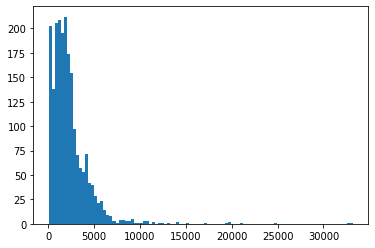

In [ ]:
plt.hist(alpha_numeric_count, bins=100)
plt.show()

In [ ]:
leaf_label = df["leaf_label"]
print(leaf_label)
frequency_leaf = collections.Counter(leaf_label)

frequency_leaf = dict(frequency_leaf)
print(frequency_leaf)

0       cricket
1       cricket
2       cricket
3       cricket
4       cricket
         ...   
2067    drought
2068    drought
2069    drought
2070    drought
2071    drought
Name: leaf_label, Length: 2072, dtype: object
{'cricket': 259, 'football': 259, 'soccer': 259, 'chess': 259, '%22forest%20fire%22': 259, 'flood': 259, 'earthquake': 259, 'drought': 259}


In [ ]:
# plt.bar(frequency_leaf.keys(), frequency_leaf.values(), color='g') # need to adjust the bins
# plt.show()

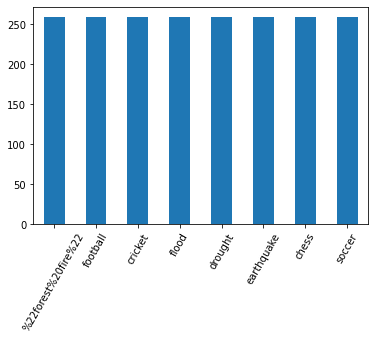

In [ ]:
leaf_label.value_counts().plot(kind='bar')
plt.xticks(rotation = 60)
plt.show()

In [ ]:
root_label = df["root_label"]
print(root_label)
frequency_root = collections.Counter(root_label)
print(dict(frequency_root))

0        sports
1        sports
2        sports
3        sports
4        sports
         ...   
2067    climate
2068    climate
2069    climate
2070    climate
2071    climate
Name: root_label, Length: 2072, dtype: object
{'sports': 1036, 'climate': 1036}


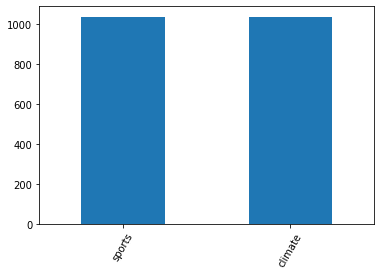

In [ ]:
root_label.value_counts().plot(kind='bar')
plt.xticks(rotation = 60)
plt.show()

SEED

In [ ]:
np.random.seed(42)
random.seed(42)

# **TRAIN TEST SPLIT AND CREATING LABELS**

In [ ]:
train, test = train_test_split(df[["full_text","root_label","leaf_label"]], test_size=0.2)
train_without_cleaning = train
test_without_cleaning = test
train_leaf = train[["full_text","leaf_label"]]
test_leaf = test[["full_text","leaf_label"]]
train = train[["full_text","root_label"]]
test = test[["full_text","root_label"]]

def generate_labels_array(df):
  labels = list()
  for label_name in df.root_label:
    if label_name == "climate":
      labels.append(1)
    elif label_name == "sports":
      labels.append(0)
  return np.array(labels)

root_label_names = ["climate", "sports"]
train_labels = generate_labels_array(train)
test_labels = generate_labels_array(test)

In [ ]:
def generate_leaf_labels_array(df):
  leaf_labels = list()
  for leaf_label_name in df.leaf_label:
    if leaf_label_name == "chess":
      leaf_labels.append(0)
    elif leaf_label_name == "cricket":
      leaf_labels.append(1)
    elif leaf_label_name == "soccer":
      leaf_labels.append(2)
    elif leaf_label_name == "football":
      leaf_labels.append(3)
    elif leaf_label_name == "%22forest%20fire%22":
      leaf_labels.append(4)
    elif leaf_label_name == "flood":
      leaf_labels.append(5)
    elif leaf_label_name == "earthquake":
      leaf_labels.append(6)
    elif leaf_label_name == "drought":
      leaf_labels.append(7)
  return np.array(leaf_labels)

leaf_label_names = ["chess", "cricket", "soccer", "football", "%22forest%20fire%22", "flood", "earthquake", "drought"]
train_leaf_labels = generate_leaf_labels_array(train_leaf)
test_leaf_labels = generate_leaf_labels_array(test_leaf)
# frequency_leaf_train = collections.Counter(train_leaf_labels)
# frequency_leaf_train = dict(frequency_leaf_train)
# frequency_leaf_train_name = collections.Counter(train_leaf["leaf_label"])
# frequency_leaf_train_name = dict(frequency_leaf_train_name)

In [ ]:
def generate_merged_labels_array(df):
  leaf_labels = list()
  for leaf_label_name in df.leaf_label:
    if leaf_label_name == "chess":
      leaf_labels.append(0)
    elif leaf_label_name == "cricket":
      leaf_labels.append(1)
    elif leaf_label_name == "soccer":
      leaf_labels.append(2)
    elif leaf_label_name == "football":
      leaf_labels.append(3)
    elif leaf_label_name == "%22forest%20fire%22":
      leaf_labels.append(4)
    elif leaf_label_name == "flood":
      leaf_labels.append(5)
    elif leaf_label_name == "earthquake":
      leaf_labels.append(5)
    elif leaf_label_name == "drought":
      leaf_labels.append(7)
  return np.array(leaf_labels)

merged_label_names = ["chess", "cricket", "soccer", "football", "%22forest%20fire%22", "flood & earthquake", "drought"]
train_merged_labels = generate_merged_labels_array(train_leaf)
test_merged_labels = generate_merged_labels_array(test_leaf)

In [ ]:
freq = {} 
for item in train_merged_labels: 
    if (item in freq): 
        freq[item] += 1
    else: 
        freq[item] = 1
print(freq)
cnt = collections.Counter(test_merged_labels)
print(cnt)

{5: 408, 4: 210, 1: 209, 7: 212, 3: 204, 2: 201, 0: 213}
Counter({5: 110, 2: 58, 3: 55, 1: 50, 4: 49, 7: 47, 0: 46})


In [ ]:
train_row, train_col = train.shape
test_row, test_col = test.shape
print(train_row, train_col)
print(test_row, test_col)
print(train_labels.shape)
print(test_labels.shape)

1657 2
415 2
(1657,)
(415,)


In [ ]:
# print(train_labels[:10])
# print(train.root_label[:10])
# print(test_labels[:10])
# print(test.root_label[:10])

In [ ]:
train_index = train.index
test_index = test.index

# **DATA CLEANING**

In [ ]:
def clean(text):
  text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
  texter = re.sub(r"<br />", " ", text)
  texter = re.sub(r"&quot;", "\"",texter)
  texter = re.sub('&#39;', "\"", texter)
  texter = re.sub('\n', " ", texter)
  texter = re.sub(' u '," you ", texter)
  texter = re.sub('`',"", texter)
  texter = re.sub(' +', ' ', texter)
  texter = re.sub(r"(!)\1+", r"!", texter)
  texter = re.sub(r"(\?)\1+", r"?", texter)
  texter = re.sub('&amp;', 'and', texter)
  texter = re.sub('\r', ' ',texter)
  texter = texter.lower()
  texter = re.sub(r'\d+', '', texter)
  clean = re.compile('<.*?>')
  texter = texter.encode('ascii', 'ignore').decode('ascii')
  texter = re.sub(clean, '', texter)
  if texter == "":
    texter = ""
  return texter

In [ ]:
for i in (train_index):
  train['full_text'][i] = clean(train['full_text'][i])

for i in (test_index):
  test['full_text'][i] = clean(test['full_text'][i])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if status.code:


In [ ]:
# print(train['full_text']) # need further sanitization
print(train['full_text'].shape)
print(test['full_text'].shape)

(1657,)
(415,)


STOPWORDS

# **STOPWORDS REMOVAL, TOKENIZATION, COUNT VECTORIZER, STEMMING, AND LEMMATIZATION**

In [ ]:
stop_words_en = stopwords.words('english')

print("# of stop_words_skt:\t\t %s" % len(stop_words_skt))
print("# of stop_words_en:\t\t %s" % len(stop_words_en))
from string import punctuation
print("# of punctuation:\t\t %s" % len(punctuation))
combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))
print("# of combined_stopwords:\t %s" % len(combined_stopwords))

# of stop_words_skt:		 318
# of stop_words_en:		 179
# of punctuation:		 32
# of combined_stopwords:	 410


In [ ]:
class Stemmer():
    def __init__(self):
        self.porter_stemmer = nltk.stem.PorterStemmer()

    def __call__(self, sentences):
        return [self.porter_stemmer.stem(t) for t in word_tokenize(sentences) if t not in combined_stopwords and not t.isdigit()]

In [ ]:
# REMOVE THIS LATER https://stackoverflow.com/questions/47423854/sklearn-adding-lemmatizer-to-countvectorizer

class LemmaTokenizer():
    def __init__(self):
        self.word_net_lemmatizer = WordNetLemmatizer()

    def __call__(self, sentences):
        return [self.word_net_lemmatizer.lemmatize(t, pos = self.pos_tag(t)) for t in word_tokenize(sentences) if t not in combined_stopwords and not t.isdigit()]
      
    def pos_tag(self, token):
      tag = nltk.pos_tag([token])[0][1][0].upper()
      tag_dict = {"J": wordnet.ADJ,
                  "N": wordnet.NOUN,
                  "V": wordnet.VERB,
                  "R": wordnet.ADV}

      return tag_dict.get(tag, wordnet.NOUN)

vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(),                         
                                stop_words = 'english',
                                lowercase = True,
                                min_df = 3)

In [ ]:
# # vectorizer = CountVectorizer(min_df=3, stop_words='english')
count_vectorizer_train_out = vectorizer.fit_transform(train.full_text)
vectorizer.get_feature_names_out()
count_vectorizer_train_out.shape

(1657, 10236)

In [ ]:
# vectorizer = CountVectorizer(min_df=3, stop_words='english')
count_vectorizer_test_out = vectorizer.transform(test.full_text)
vectorizer.get_feature_names_out()
# print(count_vectorizer_test_out.toarray())
count_vectorizer_test_out.shape

(415, 10236)

# **TF-IDF TRANSFORMER**

In [ ]:
tfidf = TfidfTransformer()
X_train = tfidf.fit_transform(count_vectorizer_train_out)
X_test = tfidf.transform(count_vectorizer_test_out)

In [ ]:
print(X_train.shape, X_test.shape)

(1657, 10236) (415, 10236)


# **PRINCIPAL COMPONENT ANALYSIS**

In [ ]:
sc = StandardScaler(with_mean=False)
X_train_scalar = sc.fit_transform(X_train)
X_test_scalar = sc.transform(X_test)

In [ ]:
# k = [1, 10, 50, 100, 200, 500, 1000, 2000]
k = [1, 10, 50, 100, 200, 500, 1000, 1657]

model = TruncatedSVD(n_components=2000, n_iter=20)
X_train_output_proc = model.fit_transform(X_train_scalar) # is the input X_train or X_train_output?

evr = model.explained_variance_ratio_

In [ ]:
print(X_train_output_proc.shape)
print(evr.shape)

(1657, 1657)
(1657,)


EXPLAINED VARIANCE RATIO

[0.011696484249142873, 0.00322774355327667, 0.0016985953043924563, 0.0013751263034434578, 0.0010955082163511996, 0.0007244926391211039, 0.00039345854883702976, 1.0416659397137225e-33]


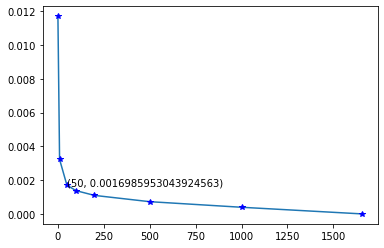

In [ ]:
evr_k = []
for i in (k):
  evr_k.append(evr[i-1])
print(evr_k)
plt.plot(k, evr_k)
for i in range(len(k)):
  plt.plot(k[i], evr_k[i],'b*')
plt.text(k[2], evr_k[2], '({}, {})'.format(k[2], evr_k[2]))
plt.show()

TRUNCATED SVD(LATENT SEMANTIC INDEXING)

In [ ]:
lsi = TruncatedSVD(n_components=50, n_iter=20, random_state=42)
lsi_train = lsi.fit_transform(X_train)
lsi_test = lsi.transform(X_test)
print(lsi_train)
Sigma = lsi.singular_values_ 
V_transpose = lsi.components_.T

[[ 0.17737255 -0.01783404  0.17307334 ...  0.0110069  -0.06174479
   0.07225865]
 [ 0.18731999  0.03794848  0.32279888 ... -0.04188581 -0.04263529
  -0.00390009]
 [ 0.17663439  0.05958838 -0.02646413 ... -0.00460793 -0.0275494
   0.09612316]
 ...
 [ 0.18078914  0.02947126 -0.01569071 ... -0.02937647  0.06334591
  -0.01204248]
 [ 0.17174576  0.02980601  0.01401381 ...  0.00203442 -0.06594591
  -0.04489675]
 [ 0.19201097 -0.11713859 -0.03725636 ... -0.02457327  0.02494027
  -0.04643776]]


In [ ]:
lsi_train_est = lsi.inverse_transform(lsi_train)
lsi_mse = np.linalg.norm(X_train - lsi_train_est) ** 2
print(lsi_mse)

1178.4102073956403


NON_NEGATIVE MATRIX FACTORIZATION

In [ ]:
nmf_model = NMF(n_components=50, init='random', random_state=42)
nmf_train = nmf_model.fit_transform(X_train)
nmf_test = nmf_model.transform(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


In [ ]:
nmf_train_est = nmf_model.inverse_transform(nmf_train)
nmf_mse = np.linalg.norm(X_train - nmf_train_est) ** 2
print(nmf_mse)

1200.0012100129704


In [ ]:
# we need the label from the datasets, which allows the calculation of accuracy rates
fprs = []
tprs = []

# **SUPPORT VECTOR MACHINES**

In [ ]:
def linear_svm(train_set, test_set, train_label, test_label, gamma='auto', C=1.0):
    plt.gcf().clear()
    svc = svm.SVC(C = C, probability=False, kernel='linear')
    svc.fit(train_set, train_label)
    svc_predicted = svc.predict(test_set)

    print('gamma: '+ str(C))
    print('Accuracy: ' + str(metrics.accuracy_score(test_label.ravel(), svc_predicted)))
    print('Precision: ' + str(metrics.precision_score(test_label.ravel(), svc_predicted, average="macro")))
    print('Recall: ' + str(metrics.recall_score(test_label.ravel(), svc_predicted, average="macro")))
    print('F-1 Score: ' + str(metrics.f1_score(test_label.ravel(), svc_predicted, average="macro")))
    print('-' * 50)
    print("ROC Curve")
    roc_curve = RocCurveDisplay.from_estimator(
                                                  svc, test_set, test_label
                                              )
    plt.show()
    print('-' * 50)
    print("Confusion Matrix")
    print('-' * 50)
    
    confusion_matrix = ConfusionMatrixDisplay.from_estimator(
                                                              svc,
                                                              test_set,
                                                              test_label,
                                                              display_labels=root_label_names,
                                                              cmap=plt.cm.Purples,
                                                            )
    
    fpr, tpr, thresholds = metrics.roc_curve(test_label, svc.decision_function(test_set),pos_label=1)
    return fpr, tpr

**SVM WITH LSI**

---



HARD-MARGIN SUPPORT VECTOR MACHINE

gamma: 1000
Accuracy: 0.9759036144578314
Precision: 0.9759780689526996
Recall: 0.9758675152134528
F-1 Score: 0.9759001161440186
--------------------------------------------------
ROC Curve


<Figure size 432x288 with 0 Axes>

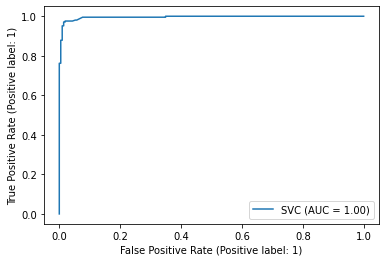

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


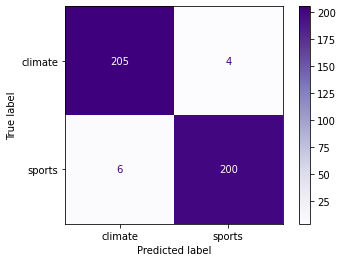

In [ ]:
# SVM using LSI, gamma = 1000
fpr,tpr = linear_svm(lsi_train, lsi_test, train_labels, test_labels, C=1000)
fprs.append(fpr)
tprs.append(tpr)

gamma: 100000
Accuracy: 0.9734939759036144
Precision: 0.9736383492889673
Recall: 0.9734403307474335
F-1 Score: 0.9734884342205368
--------------------------------------------------
ROC Curve


<Figure size 432x288 with 0 Axes>

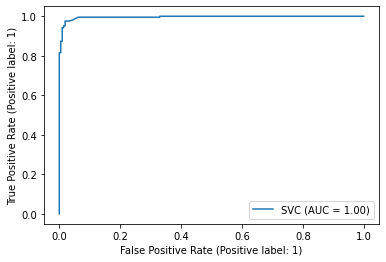

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


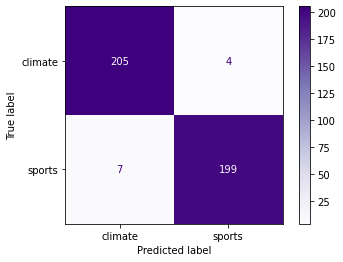

In [ ]:
# SVM using LSI, gamma = 100000
fpr,tpr = linear_svm(lsi_train, lsi_test, train_labels, test_labels, C=100000)
fprs.append(fpr)
tprs.append(tpr)

SOFT-MARGIN SUPPORT VECTOR MACHINE

gamma: 0.0001
Accuracy: 0.4963855421686747
Precision: 0.24819277108433735
Recall: 0.5
F-1 Score: 0.33172302737520126
--------------------------------------------------
ROC Curve


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 432x288 with 0 Axes>

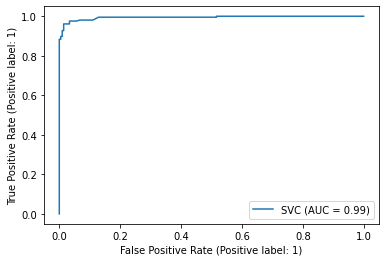

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


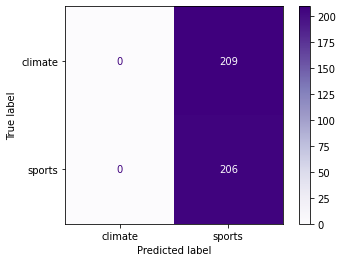

In [ ]:
# SVM using LSI, gamma = 0.0001
fpr,tpr = linear_svm(lsi_train, lsi_test, train_labels, test_labels,C=0.0001)
fprs.append(fpr)
tprs.append(tpr)

**SVM WITH NON-NEGATIVE MATRIX FACTORIZATION**

---


HARD MARGIN SUPPORT VECTOR MACHINE

gamma: 100000
Accuracy: 0.9783132530120482
Precision: 0.9784598940421972
Recall: 0.9782598597110606
F-1 Score: 0.9783087189077119
--------------------------------------------------
ROC Curve


<Figure size 432x288 with 0 Axes>

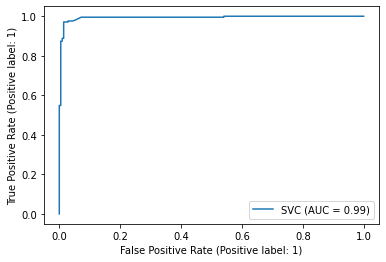

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


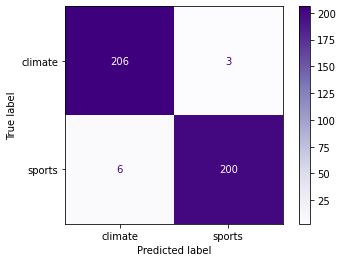

In [ ]:
# SVM using NMF, gamma = 100000
fpr,tpr = linear_svm(nmf_train, nmf_test, train_labels, test_labels, C=100000)
fprs.append(fpr)
tprs.append(tpr)

gamma: 1000
Accuracy: 0.9662650602409638
Precision: 0.9667441860465116
Recall: 0.9661587773493752
F-1 Score: 0.966249186727391
--------------------------------------------------
ROC Curve


<Figure size 432x288 with 0 Axes>

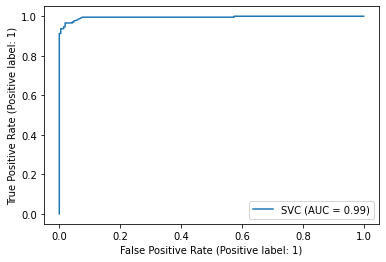

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


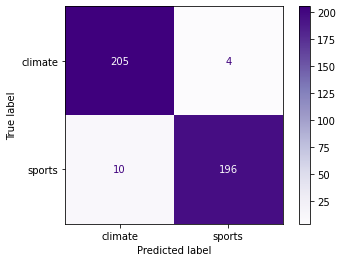

In [ ]:
# SVM using NMF, gamma = 1000
fpr,tpr = linear_svm(nmf_train, nmf_test, train_labels, test_labels, C=1000)
fprs.append(fpr)
tprs.append(tpr)

SOFT-MARGIN SUPPORT VECTOR MACHIBE

gamma: 0.0001
Accuracy: 0.4963855421686747
Precision: 0.24819277108433735
Recall: 0.5
F-1 Score: 0.33172302737520126
--------------------------------------------------
ROC Curve


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 432x288 with 0 Axes>

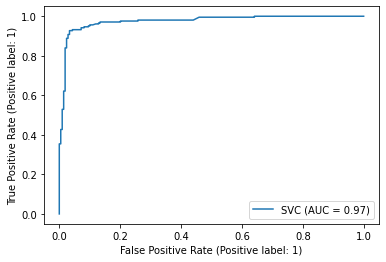

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


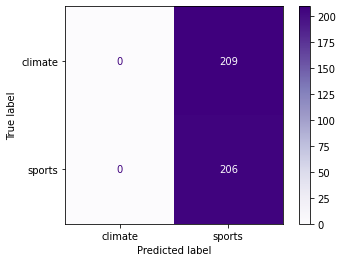

In [ ]:
# SVM using NMF, gamma = 0.0001
fpr,tpr = linear_svm(nmf_train, nmf_test, train_labels, test_labels, C=0.0001)
fprs.append(fpr)
tprs.append(tpr)

# **CROSS VALIDATION TO FIND OPTIMAL $\gamma$**

In [ ]:
def find_optimal_gamma(train_set, train_label):
    best_average_accuracy = 0
    best_gamma = 0
    for k in range(-3, 7):
        model = svm.SVC(kernel = "linear")
        model.set_params(C=10**k).fit(train_set, train_label)
        cross_validation = ShuffleSplit(n_splits = 5, test_size=0.3, random_state=42)
        accuracies = cross_val_score(model, train_set, train_label, cv=cross_validation, scoring='accuracy')
        average_accuracy = np.average(accuracies)
        print("Average validation accuracy is ", average_accuracy, " when C = ", 10 ** k)
        if best_average_accuracy < average_accuracy:
          best_average_accuracy = average_accuracy
          best_gamma = 10 ** k
    print("The model performed best when C = ", best_gamma)
    return best_gamma

best_gamma = find_optimal_gamma(lsi_train, train_labels)

Average validation accuracy is  0.4843373493975903  when C =  0.001
Average validation accuracy is  0.4843373493975903  when C =  0.01
Average validation accuracy is  0.9329317269076304  when C =  0.1
Average validation accuracy is  0.951004016064257  when C =  1
Average validation accuracy is  0.9566265060240964  when C =  10
Average validation accuracy is  0.9562248995983935  when C =  100
Average validation accuracy is  0.951004016064257  when C =  1000
Average validation accuracy is  0.9465863453815262  when C =  10000
Average validation accuracy is  0.9457831325301205  when C =  100000
Average validation accuracy is  0.9449799196787149  when C =  1000000
The model performed best when C =  10


GET MODEL USING BEST GAMMA

gamma: 10
Accuracy: 0.9734939759036144
Precision: 0.9736383492889673
Recall: 0.9734403307474335
F-1 Score: 0.9734884342205368
--------------------------------------------------
ROC Curve


<Figure size 432x288 with 0 Axes>

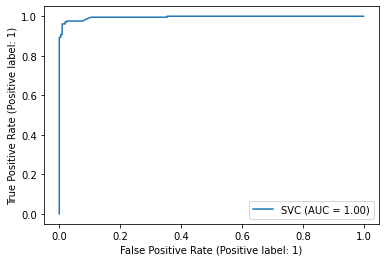

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


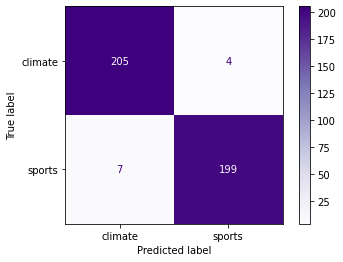

In [ ]:
# SVM using LSI, gamma = 100000
fpr,tpr = linear_svm(lsi_train, lsi_test, train_labels, test_labels, C=best_gamma)
fprs.append(fpr)
tprs.append(tpr)

# **LOGISTIC REGRESSION**

In [ ]:
def logistic_regression_model(model, train_set, test_set, train_label, test_label, gamma='auto', C = 1.0):
    plt.gcf().clear()
    model.fit(train_set, train_label)
    model_predicted = model.predict(test_set)

    print('lambda: '+ str(C))
    print('Accuracy: ' + str(metrics.accuracy_score(test_label.ravel(), model_predicted)))
    print('Precision: ' + str(metrics.precision_score(test_label.ravel(), model_predicted, average="macro")))
    print('Recall: ' + str(metrics.recall_score(test_label.ravel(), model_predicted, average="macro")))
    print('F-1 Score: ' + str(metrics.f1_score(test_label.ravel(), model_predicted, average="macro")))
    print('-' * 50)
    print("ROC Curve")
    roc_curve = RocCurveDisplay.from_estimator(
                                                  model, test_set, test_label
                                              )
    plt.show()
    print('-' * 50)
    print("Confusion Matrix")
    print('-' * 50)
    
    confusion_matrix = ConfusionMatrixDisplay.from_estimator(
                                                              model,
                                                              test_set,
                                                              test_label,
                                                              display_labels=root_label_names,
                                                              cmap=plt.cm.Purples,
                                                            )
    
    fpr, tpr, thresholds = metrics.roc_curve(test_label, model.decision_function(test_set),pos_label=1)
    return fpr, tpr

LOGISTIC REGRESSION WITHOUT REGULARIZATION

lambda: 10000000000000000000000000000000000000000000000000000000000000000
Accuracy: 0.9759036144578314
Precision: 0.9759780689526996
Recall: 0.9758675152134528
F-1 Score: 0.9759001161440186
--------------------------------------------------
ROC Curve


<Figure size 432x288 with 0 Axes>

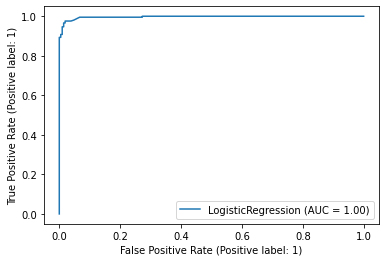

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


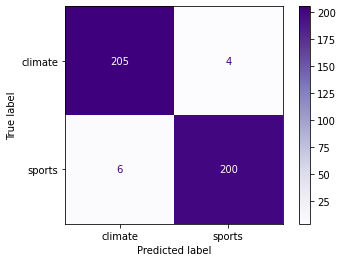

In [ ]:
logistic_regression_without_regularization = LogisticRegression(penalty='l2', C=10 ** 64, solver = 'liblinear')
_, _ = logistic_regression_model(logistic_regression_without_regularization, lsi_train, lsi_test, train_labels, test_labels, C=10**64)

# **CROSS VALIDATION TO FIND OPTIMAL $\lambda$**

In [ ]:
def find_optimal_lambda(model, train_set, train_label, penalty):
    best_average_accuracy = 0
    best_lambda = 0
    for k in range(-4, 4):
        model.set_params(penalty = penalty, C = 10 ** k).fit(train_set, train_label)
        cross_validation = ShuffleSplit(n_splits = 5, test_size=0.3, random_state=42)
        accuracies = cross_val_score(model, train_set, train_label, cv=cross_validation, scoring='accuracy')
        average_accuracy = np.average(accuracies)
        print("Average validation accuracy is ", average_accuracy, " when C = ", 10 ** k)
        if best_average_accuracy < average_accuracy:
          best_average_accuracy = average_accuracy
          best_lambda = 10 ** k
    print("The model performed best when C = ", best_lambda)

    return best_lambda

LOGISTIC REGRESSION WITH L1 REGULARIZATION

Average validation accuracy is  0.485140562248996  when C =  0.0001
Average validation accuracy is  0.485140562248996  when C =  0.001
Average validation accuracy is  0.485140562248996  when C =  0.01
Average validation accuracy is  0.8979919678714859  when C =  0.1
Average validation accuracy is  0.9461847389558233  when C =  1
Average validation accuracy is  0.9598393574297187  when C =  10
Average validation accuracy is  0.9506024096385544  when C =  100
Average validation accuracy is  0.9477911646586346  when C =  1000
The model performed best when C =  10
lambda: 10
Accuracy: 0.9759036144578314
Precision: 0.9759780689526996
Recall: 0.9758675152134528
F-1 Score: 0.9759001161440186
--------------------------------------------------
ROC Curve


<Figure size 432x288 with 0 Axes>

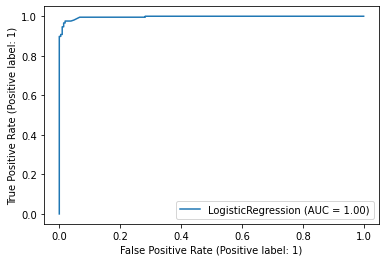

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


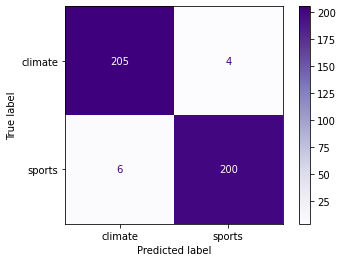

In [ ]:
logistic_regression_l1 =  LogisticRegression(penalty='l1', solver = 'liblinear')
best_lambda_l1 = find_optimal_lambda(logistic_regression_l1, lsi_train, train_labels, penalty='l1')
_, _ = logistic_regression_model(logistic_regression_l1, lsi_train, lsi_test, train_labels, test_labels, C=best_lambda_l1)

LOGISTIC REGRESSION WITH L2 REGULARIZATION

Average validation accuracy is  0.7907630522088354  when C =  0.0001
Average validation accuracy is  0.8321285140562249  when C =  0.001
Average validation accuracy is  0.9116465863453815  when C =  0.01
Average validation accuracy is  0.9357429718875501  when C =  0.1
Average validation accuracy is  0.9582329317269076  when C =  1
Average validation accuracy is  0.9606425702811243  when C =  10
Average validation accuracy is  0.9578313253012049  when C =  100
Average validation accuracy is  0.9530120481927711  when C =  1000
The model performed best when C =  10
lambda: 10
Accuracy: 0.980722891566265
Precision: 0.980798717591302
Recall: 0.98068704417708
F-1 Score: 0.9807200929152149
--------------------------------------------------
ROC Curve


<Figure size 432x288 with 0 Axes>

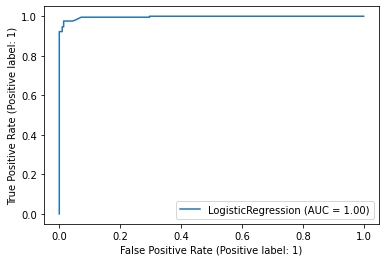

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


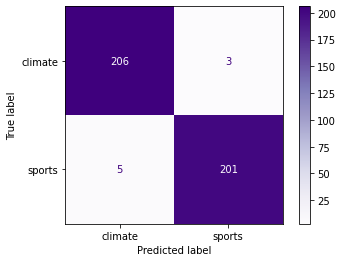

In [ ]:
logistic_regression_l2 =  LogisticRegression(penalty='l2', solver = 'liblinear')
best_lambda_l2 = find_optimal_lambda(logistic_regression_l2, lsi_train, train_labels, penalty='l2')
_, _ = logistic_regression_model(logistic_regression_l2, lsi_train, lsi_test, train_labels, test_labels, C=best_lambda_l2)

# **NAIVE BAYES CLASSIFIER**

In [ ]:
def naive_bayes_model(model, train_set, test_set, train_label, test_label, label, class_num):
    plt.gcf().clear()
    model.fit(train_set, train_label)
    model_predicted = model.predict(test_set)

    print('Accuracy: ' + str(metrics.accuracy_score(test_label.ravel(), model_predicted)))
    print('Precision: ' + str(metrics.precision_score(test_label.ravel(), model_predicted, average="macro")))
    print('Recall: ' + str(metrics.recall_score(test_label.ravel(), model_predicted, average="macro")))
    print('F-1 Score: ' + str(metrics.f1_score(test_label.ravel(), model_predicted, average="macro")))
    
    if class_num == "binary":
      print('-' * 50)
      print("ROC Curve")
      roc_curve = RocCurveDisplay.from_estimator(
                                                    model, test_set, test_label
                                                )
      plt.show()
    print('-' * 50)
    print("Confusion Matrix")
    print('-' * 50)
    if class_num == "binary":
      binary_confusion_matrix = ConfusionMatrixDisplay.from_estimator(
                                                                model,
                                                                test_set,
                                                                test_label,
                                                                display_labels=label,
                                                                cmap=plt.cm.Purples,
                                                              )
    elif class_num == "multiple":
      multiclass_NB_confusion = confusion_matrix(y_true=test_label, y_pred=model_predicted)
      multi_confusion_matrix = ConfusionMatrixDisplay(multiclass_NB_confusion,display_labels=label)
      multi_confusion_matrix.plot(cmap=plt.cm.Purples,)
      plt.xticks(rotation = 90)
      plt.show()

Accuracy: 0.9566265060240964
Precision: 0.9566378669639539
Recall: 0.9566590792957681
F-1 Score: 0.956626254180602
--------------------------------------------------
ROC Curve


<Figure size 432x288 with 0 Axes>

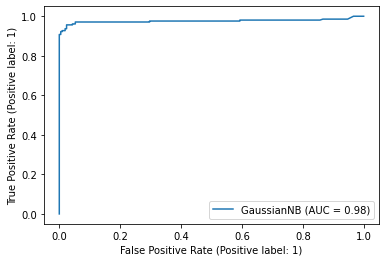

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


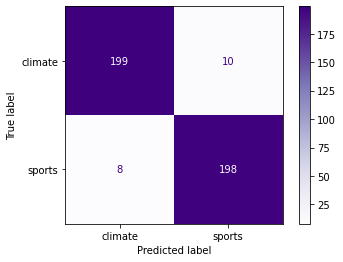

In [ ]:
gnb = GaussianNB()
naive_bayes_model(gnb, lsi_train, lsi_test, train_labels, test_labels, root_label_names, "binary")

Accuracy: 0.9710843373493976
Precision: 0.9710957822370866
Recall: 0.9711176661866494
F-1 Score: 0.9710841694537347
--------------------------------------------------
ROC Curve


<Figure size 432x288 with 0 Axes>

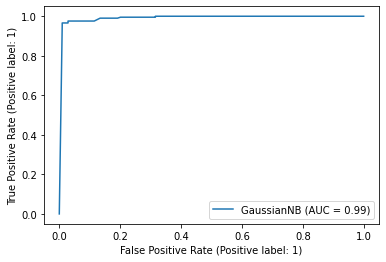

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


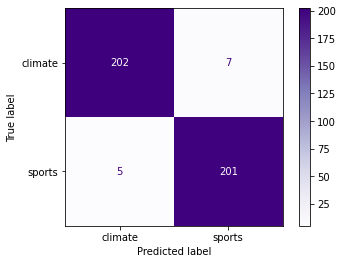

In [ ]:
naive_bayes_model(gnb, nmf_train, nmf_test, train_labels, test_labels, root_label_names, "binary")

# **GRID SEARCH OF PARAMETERS**

FEATURE EXTRACTION METHODS USED IN GRID SEARCH

In [ ]:
stem_vectorizer_3 = CountVectorizer(tokenizer=Stemmer(),                         
                                stop_words = 'english',
                                lowercase = True,
                                min_df = 3)

stem_vectorizer_5 = CountVectorizer(tokenizer=Stemmer(),                         
                                stop_words = 'english',
                                lowercase = True,
                                min_df = 5)

lemma_vectorizer_3 = CountVectorizer(tokenizer=LemmaTokenizer(),                         
                                stop_words = 'english',
                                lowercase = True,
                                min_df = 3)

lemma_vectorizer_5 = CountVectorizer(tokenizer=LemmaTokenizer(),                         
                                stop_words = 'english',
                                lowercase = True,
                                min_df = 5)

vectorizer_3 = CountVectorizer(                         
                                stop_words = 'english',
                                lowercase = True,
                                min_df = 3)

vectorizer_5 = CountVectorizer(                         
                                stop_words = 'english',
                                lowercase = True,
                                min_df = 5)

DIMENSIONALITY REDUCTION METHODS USED IN GRID SEARCH

In [ ]:
lsi_5 = TruncatedSVD(n_components=5, n_iter=20, random_state=42)
lsi_50 = TruncatedSVD(n_components=50, n_iter=20, random_state=42)
lsi_500 = TruncatedSVD(n_components=500, n_iter=20, random_state=42)

nmf_5 = NMF(n_components=5, init='random', random_state=42)
nmf_50 = NMF(n_components=50, init='random', random_state=42)
nmf_500 = NMF(n_components=500, init='random', random_state=42)

CLASSIFIERS USED IN GRID SEARCH

In [ ]:
svm_model = svm.SVC(kernel = "linear", C=best_gamma)
logistic_regression_l1 = LogisticRegression(penalty='l1', solver = 'liblinear', C = best_lambda_l1)
logistic_regression_l2 = LogisticRegression(penalty='l2', solver = 'liblinear', C = best_lambda_l2)
gaussian_naive_bayes = GaussianNB()

SETTING UP THE PIPELINE AND GRID PARAMETERS

In [ ]:
cachedir = mkdtemp()
memory = Memory(location=cachedir, verbose=10)
pipe = Pipeline([('vectorizers', vectorizer),('tfid', TfidfTransformer()),('dim_reds', lsi_5),('classifiers',gaussian_naive_bayes)], memory=memory)

In [ ]:
parameters = [
    {
        'vectorizers': [stem_vectorizer_3, stem_vectorizer_5, lemma_vectorizer_3, lemma_vectorizer_5, vectorizer_3, vectorizer_5],
        'dim_reds': [lsi_5, lsi_50, lsi_500, nmf_5, nmf_50, nmf_500],
        'classifiers': [svm_model, logistic_regression_l1, logistic_regression_l2, gaussian_naive_bayes],
    }
]

GRID SEARCH ON DATASET AFTER CLEANING

In [ ]:
grid = GridSearchCV(pipe, cv=5, n_jobs=1, param_grid=parameters, scoring='accuracy')
grid.fit(train.full_text, train_labels)
rmtree(cachedir)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(min_df=3, stop_words='english',
                tokenizer=<__main__.Stemmer object at 0x7f0c2a487d10>), 
1934    a severe drought has ravaged every county in c...
1782    "pages of history" features excerpts from the ...
1909    weather rain saturday will help with symptoms ...
1920    will the serious drought conditions afflicting...
1538    a major storm system has brought heavy rain an...
                              ...                        
1638    the redesigned ford ranger made its debut on w...
1095    (newser)  a family that died on a hike in cali...
1130    --news direct-- pano ai , the leader in wildfi...
1294    east tawas, mich.  the public is invited to a ...
860     if theres a central theme to edgar wrights new...
Name: full_text, Length: 1325, dtype: object, 
array([1, ..., 0]), None, message_clsn

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


________________________________________________fit_transform_one - 0.8s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/f3b5fb115c78f2f4282adea5fe789123
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/d150d0ed0b7c924ae814c4654c1c5898
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1325x7987 sparse matrix of type '<class 'numpy.float64'>'
	with 177651 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_tr

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 15.9s, 0.3min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/af8ffae8ce65fde8b8de9d120c9eff3a
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/1e567150368391d94da9c93fab730aff
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x7911 sparse matrix of type '<class 'numpy.float64'>'
	with 173127 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 15.5s, 0.3min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/3f6423a2824710ba2d5be7cd33d33999
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/31f6db55864568d359ab9a47c501b673
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x8064 sparse matrix of type '<class 'numpy.float64'>'
	with 177572 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 16.0s, 0.3min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/6e4b3d83a937281cb6c9e8a0b87df79f
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/cb74e9d97897d6e9aa695d8bdbeb78cf
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x8119 sparse matrix of type '<class 'numpy.float64'>'
	with 177583 stored elements in Compressed Sparse Row format>, 
array([1, ..., 1]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_tr

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 12.6s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/baf4e1b67321d3af996a142d23141a88
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/f87bd9517cbca5e0d971c95cb0bcdb29
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x5404 sparse matrix of type '<class 'numpy.float64'>'
	with 164660 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 12.4s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/bfdd49558472616cfb2497cf471dddb4
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/8160fb2dc4b802459e0748107ccd7b55
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x5511 sparse matrix of type '<class 'numpy.float64'>'
	with 168994 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 12.6s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/219a6038d58a76c1384a38c0766008c2
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/8ab1917ada878dd8e10e395be7e2fedc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x5518 sparse matrix of type '<class 'numpy.float64'>'
	with 168797 stored elements in Compressed Sparse Row format>, 
array([1, ..., 1]), None, message_clsname='Pipeline', message=None)
_______________________________________________fit_tra

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 17.1s, 0.3min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/0fee09af030a5c4674ac3266e166ab74
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/4acc0bbea6ddabf8a4e167f8af339658
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1325x9029 sparse matrix of type '<class 'numpy.float64'>'
	with 176488 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
_______________________________________________fit_tra

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 13.1s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/c57acc0f8966ca16e9a9d7072e382cfb
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/b97c14f75860c3fdef2486553c4bad68
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1325x6127 sparse matrix of type '<class 'numpy.float64'>'
	with 166702 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 13.2s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/5469b7041b3793e7a2f0a252412e405c
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/d832804fb7776848a1077d1b43c3d583
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x5974 sparse matrix of type '<class 'numpy.float64'>'
	with 163333 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_tr

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 20.3s, 0.3min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/2541a41f8484d9cae4f6ee7367593598
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/da34936107bb808605deda76b5ab8971
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x11257 sparse matrix of type '<class 'numpy.float64'>'
	with 192551 stored elements in Compressed Sparse Row format>, 
array([1, ..., 1]), None, message_clsname='Pipeline', message=None)
_______________________________________________fit_tr

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 15.0s, 0.3min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/82f7b28b2269953cfc88d54e175b8d88
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/e36c9fddfe0fc730d521b25381792d6a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x7568 sparse matrix of type '<class 'numpy.float64'>'
	with 180080 stored elements in Compressed Sparse Row format>, 
array([1, ..., 1]), None, message_clsname='Pipeline', message=None)
_______________________________________________fit_tra

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 893.4s, 14.9min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/2fda46d152170f02d9d90929d356fff4
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/ed6316014d7f892c4185e37db473f9c7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1325x8078 sparse matrix of type '<class 'numpy.float64'>'
	with 176506 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 879.1s, 14.7min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/af8ffae8ce65fde8b8de9d120c9eff3a
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/1e567150368391d94da9c93fab730aff
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1326x7911 sparse matrix of type '<class 'numpy.float64'>'
	with 173127 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 860.9s, 14.3min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/3f6423a2824710ba2d5be7cd33d33999
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/31f6db55864568d359ab9a47c501b673
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1326x8064 sparse matrix of type '<class 'numpy.float64'>'
	with 177572 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 877.1s, 14.6min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/6e4b3d83a937281cb6c9e8a0b87df79f
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/cb74e9d97897d6e9aa695d8bdbeb78cf
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1326x8119 sparse matrix of type '<class 'numpy.float64'>'
	with 177583 stored elements in Compressed Sparse Row format>, 
array([1, ..., 1]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 884.3s, 14.7min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/28a70297cf502826c5a7002837a51d5c
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/81cc833bac03a93fd6ae07304286522f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1325x5507 sparse matrix of type '<class 'numpy.float64'>'
	with 169306 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 645.4s, 10.8min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/a8b00dd0d389472a56fb07527bc9de20
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/7c171d9563e08a4176829f14fdf7074d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1325x5545 sparse matrix of type '<class 'numpy.float64'>'
	with 167990 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 644.7s, 10.7min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/baf4e1b67321d3af996a142d23141a88
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/f87bd9517cbca5e0d971c95cb0bcdb29
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1326x5404 sparse matrix of type '<class 'numpy.float64'>'
	with 164660 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 624.6s, 10.4min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/bfdd49558472616cfb2497cf471dddb4
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/8160fb2dc4b802459e0748107ccd7b55
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1326x5511 sparse matrix of type '<class 'numpy.float64'>'
	with 168994 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 637.8s, 10.6min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/219a6038d58a76c1384a38c0766008c2
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/8ab1917ada878dd8e10e395be7e2fedc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1326x5518 sparse matrix of type '<class 'numpy.float64'>'
	with 168797 stored elements in Compressed Sparse Row format>, 
array([1, ..., 1]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 642.2s, 10.7min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/b1e62ebe29556d51156692649f85628c
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/e43d9f25032e64716e7755422ba78d75
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1325x8961 sparse matrix of type '<class 'numpy.float64'>'
	with 177669 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 967.3s, 16.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/0fee09af030a5c4674ac3266e166ab74
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/4acc0bbea6ddabf8a4e167f8af339658
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1325x9029 sparse matrix of type '<class 'numpy.float64'>'
	with 176488 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 968.9s, 16.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/a509661ee5eeabe07b912b93c4de8c42
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/0c0f824e0cb9c614b3b3a281099b59de
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1326x8831 sparse matrix of type '<class 'numpy.float64'>'
	with 173000 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 952.3s, 15.9min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/8c07e76f106c3cad6b5c541834788c75
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/5f7e1404ef3ac8fd4bcb9a80b32cb4d6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1326x8967 sparse matrix of type '<class 'numpy.float64'>'
	with 177401 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
_____________________________________________fit_tran

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 969.0s, 16.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/3c10017aa347357a85d575356d64ec42
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/3b384ea51ffeb2f732a14cec9f470096
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1325x6085 sparse matrix of type '<class 'numpy.float64'>'
	with 167974 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 703.3s, 11.7min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/c57acc0f8966ca16e9a9d7072e382cfb
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/b97c14f75860c3fdef2486553c4bad68
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1325x6127 sparse matrix of type '<class 'numpy.float64'>'
	with 166702 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 703.0s, 11.7min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/5469b7041b3793e7a2f0a252412e405c
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/d832804fb7776848a1077d1b43c3d583
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1326x5974 sparse matrix of type '<class 'numpy.float64'>'
	with 163333 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 698.0s, 11.6min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/3359631c5e3f66f7fa2c08af2f9a5f94
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/48ab501b9d36bf4185e9a29dcffc34b9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1326x6098 sparse matrix of type '<class 'numpy.float64'>'
	with 167760 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
_____________________________________________fit_tran

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 704.4s, 11.7min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/a5e3b4d48808fdb905c62b67751fe345
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/4ff6626f26db2920f870f5b184433443
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1325x11116 sparse matrix of type '<class 'numpy.float64'>'
	with 192667 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


____________________________________________fit_transform_one - 1189.2s, 19.8min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/ab546337e36ba4a16732a77be2e46371
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/53b08ac0f7d1f92e943a943cb61e8ddd
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1325x11191 sparse matrix of type '<class 'numpy.float64'>'
	with 191151 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
____________________________________________fit_tran

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


____________________________________________fit_transform_one - 1164.5s, 19.4min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/5c73b414d6391a97ce60e0b76cd2ec96
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/aa5c8324ccc15283a34a46182d838517
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1326x11030 sparse matrix of type '<class 'numpy.float64'>'
	with 191952 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


____________________________________________fit_transform_one - 1187.9s, 19.8min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/2541a41f8484d9cae4f6ee7367593598
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/da34936107bb808605deda76b5ab8971
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1326x11257 sparse matrix of type '<class 'numpy.float64'>'
	with 192551 stored elements in Compressed Sparse Row format>, 
array([1, ..., 1]), None, message_clsname='Pipeline', message=None)
____________________________________________fit_tran

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 842.9s, 14.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/5ba87f4d0f5fa8f7b2f731dbae0d825f
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/a1e0011950413853181ca187ae3867a6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1325x7538 sparse matrix of type '<class 'numpy.float64'>'
	with 178782 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
_____________________________________________fit_tran

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 829.1s, 13.8min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/29f9ccfdda803a06c69f9068f930ac23
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/6f5c559090f91776bbfada3dc6c91f83
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1326x7545 sparse matrix of type '<class 'numpy.float64'>'
	with 180185 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
_____________________________________________fit_tran

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 859.7s, 14.3min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/f3b5fb115c78f2f4282adea5fe789123
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/d150d0ed0b7c924ae814c4654c1c5898
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/8560fbc753be6852d4ae9ca5f1463983
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmpvv9blhh1/joblib/sklearn/pipeline/_fit_transform_one/2fda46d152170f02d9d90929d356fff4
___________________________________fit_transform_one cache loaded - 0.1s

In [ ]:
result_after_cleaning = pd.DataFrame(grid.cv_results_)
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifiers,param_dim_reds,param_vectorizers,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,14.696486,0.678506,3.489174,0.157182,"SVC(C=10, kernel='linear')","TruncatedSVD(n_components=5, n_iter=20, random...","CountVectorizer(min_df=3, stop_words='english'...","{'classifiers': SVC(C=10, kernel='linear'), 'd...",0.933735,0.909639,0.912387,0.930514,0.891239,0.915502,0.015431,110
1,14.228285,0.165114,3.431575,0.131351,"SVC(C=10, kernel='linear')","TruncatedSVD(n_components=5, n_iter=20, random...","CountVectorizer(min_df=5, stop_words='english'...","{'classifiers': SVC(C=10, kernel='linear'), 'd...",0.933735,0.909639,0.909366,0.930514,0.885196,0.913690,0.017503,117
2,59.002310,0.546285,14.583301,0.587797,"SVC(C=10, kernel='linear')","TruncatedSVD(n_components=5, n_iter=20, random...","CountVectorizer(min_df=3, stop_words='english'...","{'classifiers': SVC(C=10, kernel='linear'), 'd...",0.939759,0.903614,0.912387,0.927492,0.891239,0.914898,0.017147,113
3,58.982680,0.727015,14.682749,0.437291,"SVC(C=10, kernel='linear')","TruncatedSVD(n_components=5, n_iter=20, random...","CountVectorizer(min_df=5, stop_words='english'...","{'classifiers': SVC(C=10, kernel='linear'), 'd...",0.939759,0.903614,0.912387,0.924471,0.888218,0.913690,0.017595,117
4,1.312577,0.025583,0.138430,0.010984,"SVC(C=10, kernel='linear')","TruncatedSVD(n_components=5, n_iter=20, random...","CountVectorizer(min_df=3, stop_words='english')","{'classifiers': SVC(C=10, kernel='linear'), 'd...",0.939759,0.915663,0.918429,0.933535,0.906344,0.922746,0.012196,93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.184124,0.004892,6.782189,0.214270,GaussianNB(),"NMF(init='random', n_components=500, random_st...","CountVectorizer(min_df=5, stop_words='english'...","{'classifiers': GaussianNB(), 'dim_reds': NMF(...",0.966867,0.972892,0.939577,0.957704,0.954683,0.958345,0.011404,57
140,0.203935,0.011553,18.990897,0.578547,GaussianNB(),"NMF(init='random', n_components=500, random_st...","CountVectorizer(min_df=3, stop_words='english'...","{'classifiers': GaussianNB(), 'dim_reds': NMF(...",0.972892,0.981928,0.948640,0.954683,0.951662,0.961961,0.013074,39
141,0.184429,0.005885,18.445489,0.573222,GaussianNB(),"NMF(init='random', n_components=500, random_st...","CountVectorizer(min_df=5, stop_words='english'...","{'classifiers': GaussianNB(), 'dim_reds': NMF(...",0.966867,0.972892,0.921450,0.960725,0.945619,0.953511,0.018419,74
142,0.227615,0.014041,4.732048,0.171242,GaussianNB(),"NMF(init='random', n_components=500, random_st...","CountVectorizer(min_df=3, stop_words='english')","{'classifiers': GaussianNB(), 'dim_reds': NMF(...",0.972892,0.978916,0.948640,0.960725,0.960725,0.964380,0.010566,27


In [ ]:
result_after_cleaning.to_csv("result_after_cleaning.csv")

GRID SEARCH ON DATASET BEFORE CLEANING

In [ ]:
grid_without_cleaning = GridSearchCV(pipe, cv=5, n_jobs=1, param_grid=parameters, scoring='accuracy')
grid_without_cleaning.fit(train_without_cleaning.full_text, train_labels)
rmtree(cachedir)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(min_df=3, stop_words='english',
                tokenizer=<__main__.Stemmer object at 0x7f19a2a43950>), 
1934    a severe drought has ravaged every county in c...
1782    "pages of history" features excerpts from the ...
1909    weather rain saturday will help with symptoms ...
1920    will the serious drought conditions afflicting...
1538    a major storm system has brought heavy rain an...
                              ...                        
1638    the redesigned ford ranger made its debut on w...
1095    (newser)  a family that died on a hike in cali...
1130    --news direct-- pano ai , the leader in wildfi...
1294    east tawas, mich.  the public is invited to a ...
860     if theres a central theme to edgar wrights new...
Name: full_text, Length: 1325, dtype: object, 
array([1, ..., 0]), None, message_clsn

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


________________________________________________fit_transform_one - 0.8s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/ccd2d394d9ea33cfd1b0a9365058b37c
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/d150d0ed0b7c924ae814c4654c1c5898
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1325x7987 sparse matrix of type '<class 'numpy.float64'>'
	with 177651 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_tr

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 15.7s, 0.3min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/9c23daaa8305cbea46919a413623b544
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/1e567150368391d94da9c93fab730aff
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x7911 sparse matrix of type '<class 'numpy.float64'>'
	with 173127 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 15.5s, 0.3min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/61e594a843619d5695af7db1e8a14744
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/31f6db55864568d359ab9a47c501b673
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x8064 sparse matrix of type '<class 'numpy.float64'>'
	with 177572 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 15.9s, 0.3min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/beedc7e0edcad3ae77d7c9de904d42c2
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/cb74e9d97897d6e9aa695d8bdbeb78cf
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x8119 sparse matrix of type '<class 'numpy.float64'>'
	with 177583 stored elements in Compressed Sparse Row format>, 
array([1, ..., 1]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_tr

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 12.4s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/1fdf5418fe6793b596c656a7d96e70d5
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/f87bd9517cbca5e0d971c95cb0bcdb29
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x5404 sparse matrix of type '<class 'numpy.float64'>'
	with 164660 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 12.2s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/025c4b710c8de3200cdc35a2f0740e9e
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/8160fb2dc4b802459e0748107ccd7b55
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x5511 sparse matrix of type '<class 'numpy.float64'>'
	with 168994 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 12.4s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/d3fd3f2926964efd4025abf42c4b1555
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/8ab1917ada878dd8e10e395be7e2fedc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x5518 sparse matrix of type '<class 'numpy.float64'>'
	with 168797 stored elements in Compressed Sparse Row format>, 
array([1, ..., 1]), None, message_clsname='Pipeline', message=None)
_______________________________________________fit_tra

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 16.6s, 0.3min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/0fee09af030a5c4674ac3266e166ab74
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/4acc0bbea6ddabf8a4e167f8af339658
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1325x9029 sparse matrix of type '<class 'numpy.float64'>'
	with 176488 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
_______________________________________________fit_tra

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 12.9s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/c57acc0f8966ca16e9a9d7072e382cfb
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/b97c14f75860c3fdef2486553c4bad68
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1325x6127 sparse matrix of type '<class 'numpy.float64'>'
	with 166702 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 12.9s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/5469b7041b3793e7a2f0a252412e405c
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/d832804fb7776848a1077d1b43c3d583
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x5974 sparse matrix of type '<class 'numpy.float64'>'
	with 163333 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_tr

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 19.9s, 0.3min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/2541a41f8484d9cae4f6ee7367593598
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/da34936107bb808605deda76b5ab8971
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x11257 sparse matrix of type '<class 'numpy.float64'>'
	with 192551 stored elements in Compressed Sparse Row format>, 
array([1, ..., 1]), None, message_clsname='Pipeline', message=None)
_______________________________________________fit_tr

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_______________________________________________fit_transform_one - 14.9s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/82f7b28b2269953cfc88d54e175b8d88
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/e36c9fddfe0fc730d521b25381792d6a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <1326x7568 sparse matrix of type '<class 'numpy.float64'>'
	with 180080 stored elements in Compressed Sparse Row format>, 
array([1, ..., 1]), None, message_clsname='Pipeline', message=None)
_______________________________________________fit_tra

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 887.2s, 14.8min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/eca16e46eaa5f725a3b82ee9aa70fdd6
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/ed6316014d7f892c4185e37db473f9c7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1325x8078 sparse matrix of type '<class 'numpy.float64'>'
	with 176506 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 890.4s, 14.8min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/9c23daaa8305cbea46919a413623b544
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/1e567150368391d94da9c93fab730aff
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1326x7911 sparse matrix of type '<class 'numpy.float64'>'
	with 173127 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 870.6s, 14.5min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/61e594a843619d5695af7db1e8a14744
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/31f6db55864568d359ab9a47c501b673
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1326x8064 sparse matrix of type '<class 'numpy.float64'>'
	with 177572 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 881.5s, 14.7min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/beedc7e0edcad3ae77d7c9de904d42c2
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/cb74e9d97897d6e9aa695d8bdbeb78cf
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1326x8119 sparse matrix of type '<class 'numpy.float64'>'
	with 177583 stored elements in Compressed Sparse Row format>, 
array([1, ..., 1]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 886.7s, 14.8min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/3b29768f203bdfbc087977cf2ea73e84
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/81cc833bac03a93fd6ae07304286522f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1325x5507 sparse matrix of type '<class 'numpy.float64'>'
	with 169306 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 653.6s, 10.9min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/bb64a1b64c8bf6579abd9857971a8795
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/7c171d9563e08a4176829f14fdf7074d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1325x5545 sparse matrix of type '<class 'numpy.float64'>'
	with 167990 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 653.1s, 10.9min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/1fdf5418fe6793b596c656a7d96e70d5
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/f87bd9517cbca5e0d971c95cb0bcdb29
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1326x5404 sparse matrix of type '<class 'numpy.float64'>'
	with 164660 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 638.8s, 10.6min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/025c4b710c8de3200cdc35a2f0740e9e
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/8160fb2dc4b802459e0748107ccd7b55
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1326x5511 sparse matrix of type '<class 'numpy.float64'>'
	with 168994 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 651.8s, 10.9min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/d3fd3f2926964efd4025abf42c4b1555
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/8ab1917ada878dd8e10e395be7e2fedc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1326x5518 sparse matrix of type '<class 'numpy.float64'>'
	with 168797 stored elements in Compressed Sparse Row format>, 
array([1, ..., 1]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 648.5s, 10.8min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/b1e62ebe29556d51156692649f85628c
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/e43d9f25032e64716e7755422ba78d75
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1325x8961 sparse matrix of type '<class 'numpy.float64'>'
	with 177669 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 960.8s, 16.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/0fee09af030a5c4674ac3266e166ab74
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/4acc0bbea6ddabf8a4e167f8af339658
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1325x9029 sparse matrix of type '<class 'numpy.float64'>'
	with 176488 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 965.6s, 16.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/a509661ee5eeabe07b912b93c4de8c42
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/0c0f824e0cb9c614b3b3a281099b59de
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1326x8831 sparse matrix of type '<class 'numpy.float64'>'
	with 173000 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 957.2s, 16.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/8c07e76f106c3cad6b5c541834788c75
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/5f7e1404ef3ac8fd4bcb9a80b32cb4d6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1326x8967 sparse matrix of type '<class 'numpy.float64'>'
	with 177401 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
_____________________________________________fit_tran

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 974.5s, 16.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/3c10017aa347357a85d575356d64ec42
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/3b384ea51ffeb2f732a14cec9f470096
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1325x6085 sparse matrix of type '<class 'numpy.float64'>'
	with 167974 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 707.1s, 11.8min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/c57acc0f8966ca16e9a9d7072e382cfb
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/b97c14f75860c3fdef2486553c4bad68
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1325x6127 sparse matrix of type '<class 'numpy.float64'>'
	with 166702 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 709.0s, 11.8min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/5469b7041b3793e7a2f0a252412e405c
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/d832804fb7776848a1077d1b43c3d583
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1326x5974 sparse matrix of type '<class 'numpy.float64'>'
	with 163333 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 694.1s, 11.6min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/3359631c5e3f66f7fa2c08af2f9a5f94
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/48ab501b9d36bf4185e9a29dcffc34b9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1326x6098 sparse matrix of type '<class 'numpy.float64'>'
	with 167760 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
_____________________________________________fit_tran

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 703.6s, 11.7min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/a5e3b4d48808fdb905c62b67751fe345
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/4ff6626f26db2920f870f5b184433443
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1325x11116 sparse matrix of type '<class 'numpy.float64'>'
	with 192667 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


____________________________________________fit_transform_one - 1194.3s, 19.9min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/ab546337e36ba4a16732a77be2e46371
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/53b08ac0f7d1f92e943a943cb61e8ddd
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1325x11191 sparse matrix of type '<class 'numpy.float64'>'
	with 191151 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
____________________________________________fit_tran

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


____________________________________________fit_transform_one - 1147.0s, 19.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/5c73b414d6391a97ce60e0b76cd2ec96
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/aa5c8324ccc15283a34a46182d838517
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1326x11030 sparse matrix of type '<class 'numpy.float64'>'
	with 191952 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


____________________________________________fit_transform_one - 1159.0s, 19.3min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/2541a41f8484d9cae4f6ee7367593598
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/da34936107bb808605deda76b5ab8971
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1326x11257 sparse matrix of type '<class 'numpy.float64'>'
	with 192551 stored elements in Compressed Sparse Row format>, 
array([1, ..., 1]), None, message_clsname='Pipeline', message=None)
____________________________________________fit_tran

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 844.5s, 14.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/5ba87f4d0f5fa8f7b2f731dbae0d825f
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/a1e0011950413853181ca187ae3867a6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1325x7538 sparse matrix of type '<class 'numpy.float64'>'
	with 178782 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
_____________________________________________fit_tran

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 830.9s, 13.8min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/29f9ccfdda803a06c69f9068f930ac23
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/6f5c559090f91776bbfada3dc6c91f83
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=500, random_state=42), <1326x7545 sparse matrix of type '<class 'numpy.float64'>'
	with 180185 stored elements in Compressed Sparse Row format>, 
array([1, ..., 0]), None, message_clsname='Pipeline', message=None)
_____________________________________________fit_tran

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


_____________________________________________fit_transform_one - 846.0s, 14.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/ccd2d394d9ea33cfd1b0a9365058b37c
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/d150d0ed0b7c924ae814c4654c1c5898
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/8560fbc753be6852d4ae9ca5f1463983
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /tmp/tmptlkr68oz/joblib/sklearn/pipeline/_fit_transform_one/eca16e46eaa5f725a3b82ee9aa70fdd6
___________________________________fit_transform_one cache loaded - 0.1s

In [ ]:
result_without_cleaning = pd.DataFrame(grid_without_cleaning.cv_results_)
pd.DataFrame(grid_without_cleaning.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifiers,param_dim_reds,param_vectorizers,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,14.581889,0.180782,3.465102,0.127248,"SVC(C=10, kernel='linear')","TruncatedSVD(n_components=5, n_iter=20, random...","CountVectorizer(min_df=3, stop_words='english'...","{'classifiers': SVC(C=10, kernel='linear'), 'd...",0.933735,0.909639,0.912387,0.930514,0.891239,0.915502,0.015431,110
1,14.425524,0.115285,3.467351,0.143374,"SVC(C=10, kernel='linear')","TruncatedSVD(n_components=5, n_iter=20, random...","CountVectorizer(min_df=5, stop_words='english'...","{'classifiers': SVC(C=10, kernel='linear'), 'd...",0.933735,0.909639,0.909366,0.930514,0.885196,0.913690,0.017503,117
2,60.214507,0.474699,14.900069,0.710050,"SVC(C=10, kernel='linear')","TruncatedSVD(n_components=5, n_iter=20, random...","CountVectorizer(min_df=3, stop_words='english'...","{'classifiers': SVC(C=10, kernel='linear'), 'd...",0.939759,0.903614,0.912387,0.927492,0.891239,0.914898,0.017147,113
3,59.807625,0.923133,14.735494,0.563624,"SVC(C=10, kernel='linear')","TruncatedSVD(n_components=5, n_iter=20, random...","CountVectorizer(min_df=5, stop_words='english'...","{'classifiers': SVC(C=10, kernel='linear'), 'd...",0.939759,0.903614,0.912387,0.924471,0.888218,0.913690,0.017595,117
4,1.362114,0.087009,0.138638,0.007067,"SVC(C=10, kernel='linear')","TruncatedSVD(n_components=5, n_iter=20, random...","CountVectorizer(min_df=3, stop_words='english')","{'classifiers': SVC(C=10, kernel='linear'), 'd...",0.939759,0.915663,0.918429,0.933535,0.906344,0.922746,0.012196,93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.282879,0.039455,7.129036,0.921461,GaussianNB(),"NMF(init='random', n_components=500, random_st...","CountVectorizer(min_df=5, stop_words='english'...","{'classifiers': GaussianNB(), 'dim_reds': NMF(...",0.966867,0.972892,0.939577,0.957704,0.954683,0.958345,0.011404,57
140,0.211842,0.035980,18.815635,0.554713,GaussianNB(),"NMF(init='random', n_components=500, random_st...","CountVectorizer(min_df=3, stop_words='english'...","{'classifiers': GaussianNB(), 'dim_reds': NMF(...",0.972892,0.981928,0.948640,0.954683,0.951662,0.961961,0.013074,39
141,0.187953,0.018131,18.280135,0.496865,GaussianNB(),"NMF(init='random', n_components=500, random_st...","CountVectorizer(min_df=5, stop_words='english'...","{'classifiers': GaussianNB(), 'dim_reds': NMF(...",0.966867,0.972892,0.921450,0.960725,0.945619,0.953511,0.018419,74
142,0.218706,0.026303,4.824994,0.259987,GaussianNB(),"NMF(init='random', n_components=500, random_st...","CountVectorizer(min_df=3, stop_words='english')","{'classifiers': GaussianNB(), 'dim_reds': NMF(...",0.972892,0.978916,0.948640,0.960725,0.960725,0.964380,0.010566,27


In [ ]:
result_without_cleaning.to_csv("result_without_cleaning.csv")

#TESTING THE 5 BEST HYPERPARAMETER COMBINATIONS ON CLEAN TEST DATA

BEST COMBINATION

lambda: 10
Accuracy: 0.9734939759036144
Precision: 0.9741415410385259
Recall: 0.9733706508106099
F-1 Score: 0.9734785766158316
--------------------------------------------------
ROC Curve


<Figure size 432x288 with 0 Axes>

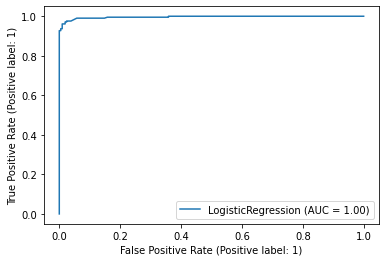

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


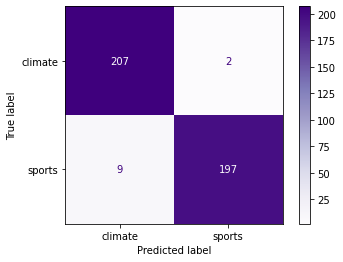

In [ ]:
stem_vectorizer_3 = CountVectorizer(tokenizer=Stemmer(),                         
                                stop_words = 'english',
                                lowercase = True,
                                min_df = 3)

stem_vectorizer_3_train_out = stem_vectorizer_3.fit_transform(train.full_text)
stem_vectorizer_3_test_out = stem_vectorizer_3.transform(test.full_text)

stem_vectorizer_3_X_train = tfidf.fit_transform(stem_vectorizer_3_train_out)
stem_vectorizer_3_X_test = tfidf.transform(stem_vectorizer_3_test_out)

lsi = TruncatedSVD(n_components=500, n_iter=20, random_state=42)
lsi_stem_vectorizer_3_X_train = lsi.fit_transform(stem_vectorizer_3_X_train)
lsi_stem_vectorizer_3_X_test = lsi.transform(stem_vectorizer_3_X_test)

logistic_regression_l1 =  LogisticRegression(penalty='l1', solver = 'liblinear')
_, _ = logistic_regression_model(logistic_regression_l1, lsi_stem_vectorizer_3_X_train, lsi_stem_vectorizer_3_X_test, train_labels, test_labels, C=10)

2ND BEST COMBINATION

lambda: 10
Accuracy: 0.980722891566265
Precision: 0.9815668202764978
Recall: 0.9805825242718447
F-1 Score: 0.9807093385394877
--------------------------------------------------
ROC Curve


<Figure size 432x288 with 0 Axes>

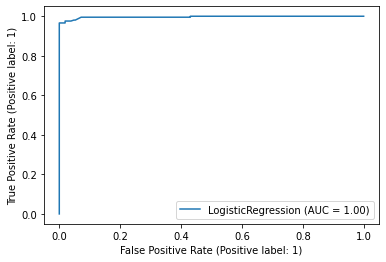

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


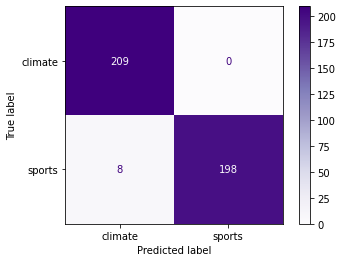

In [ ]:
vectorizer_3 = CountVectorizer(                         
                                stop_words = 'english',
                                lowercase = True,
                                min_df = 3)

vectorizer_3_train_out = vectorizer_3.fit_transform(train.full_text)
vectorizer_3_test_out = vectorizer_3.transform(test.full_text)

vectorizer_3_X_train = tfidf.fit_transform(vectorizer_3_train_out)
vectorizer_3_X_test = tfidf.transform(vectorizer_3_test_out)

lsi = TruncatedSVD(n_components=500, n_iter=20, random_state=42)
lsi_vectorizer_3_X_train = lsi.fit_transform(vectorizer_3_X_train)
lsi_vectorizer_3_X_test = lsi.transform(vectorizer_3_X_test)

logistic_regression_without_regularization = LogisticRegression(penalty='l2', C=10, solver = 'liblinear')
_, _ = logistic_regression_model(logistic_regression_without_regularization, lsi_vectorizer_3_X_train, lsi_vectorizer_3_X_test, train_labels, test_labels, C=10)

3RD BEST COMBINATION

lambda: 10
Accuracy: 0.9759036144578314
Precision: 0.9767374202858073
Recall: 0.9757629953082176
F-1 Score: 0.9758866731743596
--------------------------------------------------
ROC Curve


<Figure size 432x288 with 0 Axes>

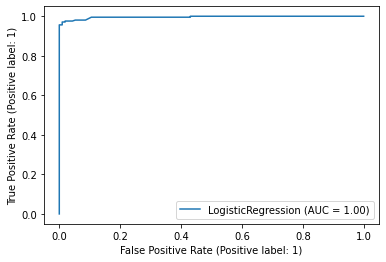

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


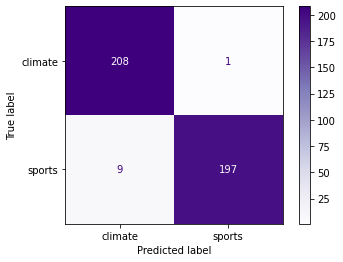

In [ ]:
lemma_vectorizer_5 = CountVectorizer(tokenizer=LemmaTokenizer(),                         
                                stop_words = 'english',
                                lowercase = True,
                                min_df = 5)

lemma_vectorizer_5_train_out = lemma_vectorizer_5.fit_transform(train.full_text)
lemma_vectorizer_5_test_out = lemma_vectorizer_5.transform(test.full_text)

lemma_vectorizer_5_X_train = tfidf.fit_transform(lemma_vectorizer_5_train_out)
lemma_vectorizer_5_X_test = tfidf.transform(lemma_vectorizer_5_test_out)

lsi = TruncatedSVD(n_components=500, n_iter=20, random_state=42)
lsi_lemma_vectorizer_5_X_train = lsi.fit_transform(lemma_vectorizer_5_X_train)
lsi_lemma_vectorizer_5_X_test = lsi.transform(lemma_vectorizer_5_X_test)

logistic_regression_l1 =  LogisticRegression(penalty='l2', solver = 'liblinear')
_, _ = logistic_regression_model(logistic_regression_l1, lsi_lemma_vectorizer_5_X_train, lsi_lemma_vectorizer_5_X_test, train_labels, test_labels, C=10)

4th BEST COMBINATION

gamma: 10
Accuracy: 0.9759036144578314
Precision: 0.9767374202858073
Recall: 0.9757629953082176
F-1 Score: 0.9758866731743596
--------------------------------------------------
ROC Curve


<Figure size 432x288 with 0 Axes>

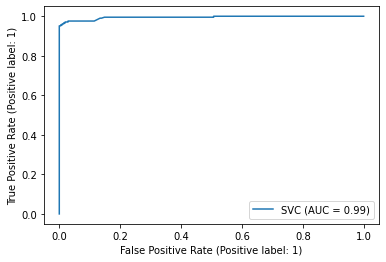

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


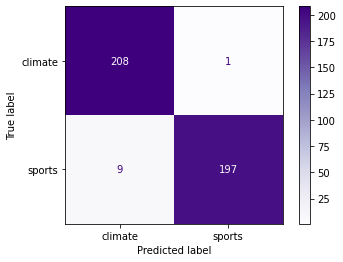

In [ ]:
vectorizer_5 = CountVectorizer(                         
                                stop_words = 'english',
                                lowercase = True,
                                min_df = 5)

vectorizer_5_train_out = vectorizer_5.fit_transform(train.full_text)
vectorizer_5_test_out = vectorizer_5.transform(test.full_text)

vectorizer_5_X_train = tfidf.fit_transform(vectorizer_5_train_out)
vectorizer_5_X_test = tfidf.transform(vectorizer_5_test_out)

lsi = TruncatedSVD(n_components=500, n_iter=20, random_state=42)
lsi_vectorizer_5_X_train = lsi.fit_transform(vectorizer_5_X_train)
lsi_vectorizer_5_X_test = lsi.transform(vectorizer_5_X_test)

_,_ = linear_svm(lsi_vectorizer_5_X_train, lsi_vectorizer_5_X_test, train_labels, test_labels, C=10)

5TH BEST COMBINATION

lambda: 10
Accuracy: 0.980722891566265
Precision: 0.9815668202764978
Recall: 0.9805825242718447
F-1 Score: 0.9807093385394877
--------------------------------------------------
ROC Curve


<Figure size 432x288 with 0 Axes>

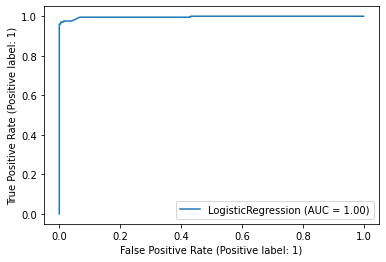

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


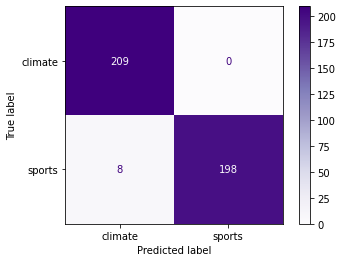

In [ ]:
vectorizer_5 = CountVectorizer(                         
                                stop_words = 'english',
                                lowercase = True,
                                min_df = 5)

vectorizer_5_train_out = vectorizer_5.fit_transform(train.full_text)
vectorizer_5_test_out = vectorizer_5.transform(test.full_text)

vectorizer_5_X_train = tfidf.fit_transform(vectorizer_5_train_out)
vectorizer_5_X_test = tfidf.transform(vectorizer_5_test_out)

lsi = TruncatedSVD(n_components=500, n_iter=20, random_state=42)
lsi_vectorizer_5_X_train = lsi.fit_transform(vectorizer_5_X_train)
lsi_vectorizer_5_X_test = lsi.transform(vectorizer_5_X_test)

logistic_regression_without_regularization = LogisticRegression(penalty='l2', C=10, solver = 'liblinear')
_, _ = logistic_regression_model(logistic_regression_without_regularization, lsi_vectorizer_5_X_train, lsi_vectorizer_5_X_test, train_labels, test_labels, C=10)

#TESTING THE 5 BEST HYPERPARAMETER COMBINATIONS ON RAW TEST DATA

BEST COMBINATION

lambda: 10
Accuracy: 0.9662650602409638
Precision: 0.9670786203044268
Recall: 0.9661239373809635
F-1 Score: 0.9662413424441035
--------------------------------------------------
ROC Curve


<Figure size 432x288 with 0 Axes>

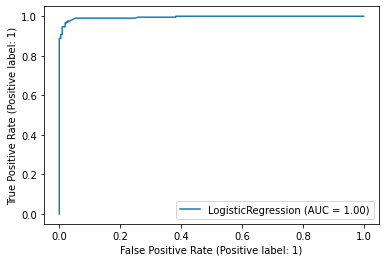

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


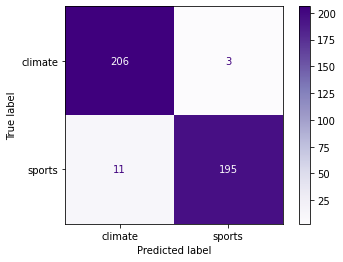

In [ ]:
stem_vectorizer_3 = CountVectorizer(tokenizer=Stemmer(),                         
                                stop_words = 'english',
                                lowercase = True,
                                min_df = 3)

stem_vectorizer_3_train_out = stem_vectorizer_3.fit_transform(train_without_cleaning.full_text)
stem_vectorizer_3_test_out = stem_vectorizer_3.transform(test_without_cleaning.full_text)

stem_vectorizer_3_X_train = tfidf.fit_transform(stem_vectorizer_3_train_out)
stem_vectorizer_3_X_test = tfidf.transform(stem_vectorizer_3_test_out)

lsi = TruncatedSVD(n_components=500, n_iter=20, random_state=42)
lsi_stem_vectorizer_3_X_train = lsi.fit_transform(stem_vectorizer_3_X_train)
lsi_stem_vectorizer_3_X_test = lsi.transform(stem_vectorizer_3_X_test)

logistic_regression_l1 =  LogisticRegression(penalty='l1', solver = 'liblinear')
_, _ = logistic_regression_model(logistic_regression_l1, lsi_stem_vectorizer_3_X_train, lsi_stem_vectorizer_3_X_test, train_labels, test_labels, C=10)

2ND BEST COMBINATION

lambda: 10
Accuracy: 0.980722891566265
Precision: 0.9815668202764978
Recall: 0.9805825242718447
F-1 Score: 0.9807093385394877
--------------------------------------------------
ROC Curve


<Figure size 432x288 with 0 Axes>

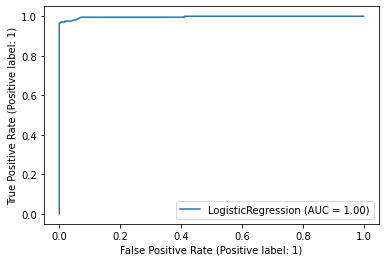

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


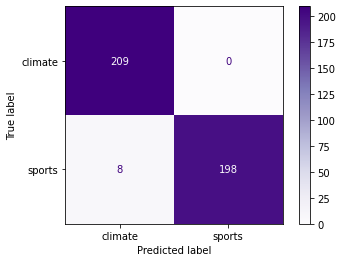

In [ ]:
vectorizer_3 = CountVectorizer(                         
                                stop_words = 'english',
                                lowercase = True,
                                min_df = 3)

vectorizer_3_train_out = vectorizer_3.fit_transform(train_without_cleaning.full_text)
vectorizer_3_test_out = vectorizer_3.transform(test_without_cleaning.full_text)

vectorizer_3_X_train = tfidf.fit_transform(vectorizer_3_train_out)
vectorizer_3_X_test = tfidf.transform(vectorizer_3_test_out)

lsi = TruncatedSVD(n_components=500, n_iter=20, random_state=42)
lsi_vectorizer_3_X_train = lsi.fit_transform(vectorizer_3_X_train)
lsi_vectorizer_3_X_test = lsi.transform(vectorizer_3_X_test)

logistic_regression_without_regularization = LogisticRegression(penalty='l2', C=10, solver = 'liblinear')
_, _ = logistic_regression_model(logistic_regression_without_regularization, lsi_vectorizer_3_X_train, lsi_vectorizer_3_X_test, train_labels, test_labels, C=10)

3RD BEST COMBINATION

lambda: 10
Accuracy: 0.9759036144578314
Precision: 0.9767374202858073
Recall: 0.9757629953082176
F-1 Score: 0.9758866731743596
--------------------------------------------------
ROC Curve


<Figure size 432x288 with 0 Axes>

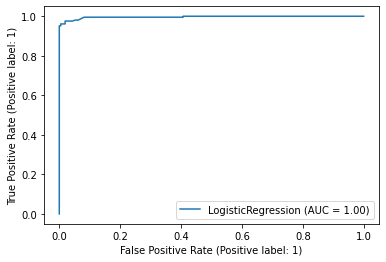

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


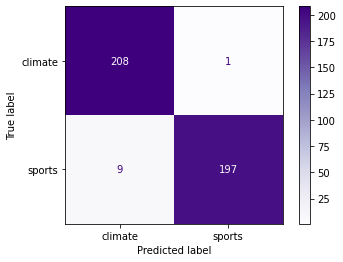

In [ ]:
lemma_vectorizer_5 = CountVectorizer(tokenizer=LemmaTokenizer(),                         
                                stop_words = 'english',
                                lowercase = True,
                                min_df = 5)

lemma_vectorizer_5_train_out = lemma_vectorizer_5.fit_transform(train_without_cleaning.full_text)
lemma_vectorizer_5_test_out = lemma_vectorizer_5.transform(test_without_cleaning.full_text)

lemma_vectorizer_5_X_train = tfidf.fit_transform(lemma_vectorizer_5_train_out)
lemma_vectorizer_5_X_test = tfidf.transform(lemma_vectorizer_5_test_out)

lsi = TruncatedSVD(n_components=500, n_iter=20, random_state=42)
lsi_lemma_vectorizer_5_X_train = lsi.fit_transform(lemma_vectorizer_5_X_train)
lsi_lemma_vectorizer_5_X_test = lsi.transform(lemma_vectorizer_5_X_test)

logistic_regression_l1 =  LogisticRegression(penalty='l2', solver = 'liblinear')
_, _ = logistic_regression_model(logistic_regression_l1, lsi_lemma_vectorizer_5_X_train, lsi_lemma_vectorizer_5_X_test, train_labels, test_labels, C=10)

4th BEST COMBINATION

gamma: 10
Accuracy: 0.9783132530120482
Precision: 0.9789689186674111
Recall: 0.978190179774237
F-1 Score: 0.9783006535947711
--------------------------------------------------
ROC Curve


<Figure size 432x288 with 0 Axes>

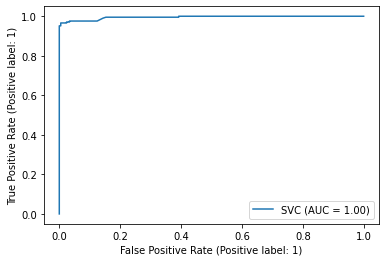

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


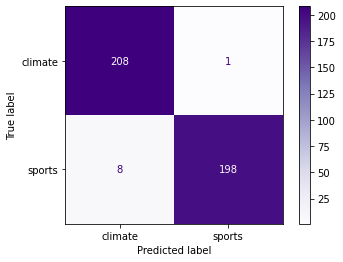

In [ ]:
vectorizer_5 = CountVectorizer(                         
                                stop_words = 'english',
                                lowercase = True,
                                min_df = 5)

vectorizer_5_train_out = vectorizer_5.fit_transform(train_without_cleaning.full_text)
vectorizer_5_test_out = vectorizer_5.transform(test_without_cleaning.full_text)

vectorizer_5_X_train = tfidf.fit_transform(vectorizer_5_train_out)
vectorizer_5_X_test = tfidf.transform(vectorizer_5_test_out)

lsi = TruncatedSVD(n_components=500, n_iter=20, random_state=42)
lsi_vectorizer_5_X_train = lsi.fit_transform(vectorizer_5_X_train)
lsi_vectorizer_5_X_test = lsi.transform(vectorizer_5_X_test)

_,_ = linear_svm(lsi_vectorizer_5_X_train, lsi_vectorizer_5_X_test, train_labels, test_labels, C=10)

5TH BEST COMBINATION

lambda: 10
Accuracy: 0.983132530120482
Precision: 0.9837962962962963
Recall: 0.9830097087378641
F-1 Score: 0.9831227305737109
--------------------------------------------------
ROC Curve


<Figure size 432x288 with 0 Axes>

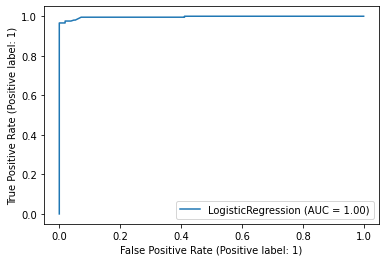

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


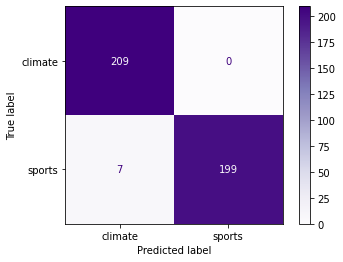

In [ ]:
vectorizer_5 = CountVectorizer(                         
                                stop_words = 'english',
                                lowercase = True,
                                min_df = 5)

vectorizer_5_train_out = vectorizer_5.fit_transform(train_without_cleaning.full_text)
vectorizer_5_test_out = vectorizer_5.transform(test_without_cleaning.full_text)

vectorizer_5_X_train = tfidf.fit_transform(vectorizer_5_train_out)
vectorizer_5_X_test = tfidf.transform(vectorizer_5_test_out)

lsi = TruncatedSVD(n_components=500, n_iter=20, random_state=42)
lsi_vectorizer_5_X_train = lsi.fit_transform(vectorizer_5_X_train)
lsi_vectorizer_5_X_test = lsi.transform(vectorizer_5_X_test)

logistic_regression_without_regularization = LogisticRegression(penalty='l2', C=10, solver = 'liblinear')
_, _ = logistic_regression_model(logistic_regression_without_regularization, lsi_vectorizer_5_X_train, lsi_vectorizer_5_X_test, train_labels, test_labels, C=10)

# **MULTICLASS CLASSIFICATION**

In [ ]:
def multi_svm(model, train_set, test_set, train_label, test_label, gamma='auto', C=1.0):
    plt.gcf().clear()
    model.fit(train_set, train_label)
    model_predicted = model.predict(test_set)

    print('Accuracy: ' + str(metrics.accuracy_score(test_label.ravel(), model_predicted)))
    print('Precision: ' + str(metrics.precision_score(test_label.ravel(), model_predicted, average="macro")))
    print('Recall: ' + str(metrics.recall_score(test_label.ravel(), model_predicted, average="macro")))
    print('F-1 Score: ' + str(metrics.f1_score(test_label.ravel(), model_predicted, average="macro")))

    plt.show()
    print('-' * 50)
    print("Confusion Matrix")
    print('-' * 50)
    
    multi_svm_confusion = confusion_matrix(y_true=test_label, y_pred=model_predicted)
    multi_confusion_matrix = ConfusionMatrixDisplay(multi_svm_confusion,display_labels=leaf_label_names)
    multi_confusion_matrix.plot(cmap=plt.cm.Purples,)
    plt.xticks(rotation = 90)
    plt.show()
    

In [ ]:
def multi_svm_imbalance(model, train_set, test_set, train_label, test_label, gamma='auto', C=1.0):
    plt.gcf().clear()
    model.fit(train_set, train_label)
    model_predicted = model.predict(test_set)

    print('Accuracy: ' + str(metrics.accuracy_score(test_label.ravel(), model_predicted)))
    print('Precision: ' + str(metrics.precision_score(test_label.ravel(), model_predicted, average="macro")))
    print('Recall: ' + str(metrics.recall_score(test_label.ravel(), model_predicted, average="macro")))
    print('F-1 Score: ' + str(metrics.f1_score(test_label.ravel(), model_predicted, average="macro")))

    plt.show()
    print('-' * 50)
    print("Confusion Matrix")
    print('-' * 50)
    
    multi_svm_confusion = confusion_matrix(y_true=test_label, y_pred=model_predicted)
    multi_confusion_matrix = ConfusionMatrixDisplay(multi_svm_confusion,display_labels=merged_label_names)
    multi_confusion_matrix.plot(cmap=plt.cm.Purples,)
    plt.xticks(rotation = 90)
    plt.show()

NAIVE BAYES CLASSIFIER WITH LSI

Accuracy: 0.8626506024096385
Precision: 0.8679333165208458
Recall: 0.8633910936763298
F-1 Score: 0.8622118439302451
--------------------------------------------------
Confusion Matrix
--------------------------------------------------


<Figure size 432x288 with 0 Axes>

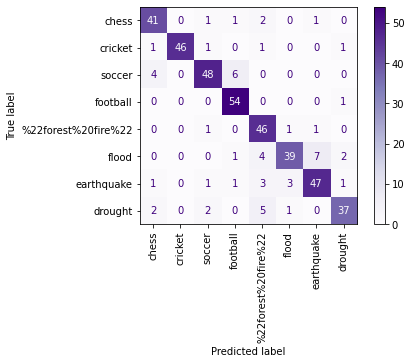

In [ ]:
mult_class = GaussianNB()
naive_bayes_model(mult_class, lsi_train, lsi_test, train_leaf_labels, test_leaf_labels, leaf_label_names, "multiple")

In [ ]:
# naive_bayes_model(mult_class, lsi_train, lsi_test, train_merged_labels, test_merged_labels, merged_label_names, "multiple")

NAIVE BAYES CLASSIFIER WITH NMF

Accuracy: 0.8626506024096385
Precision: 0.8672069256303454
Recall: 0.865096975629346
F-1 Score: 0.8658326732362084
--------------------------------------------------
Confusion Matrix
--------------------------------------------------


<Figure size 432x288 with 0 Axes>

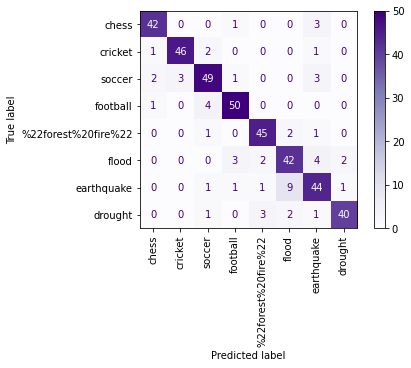

In [ ]:
naive_bayes_model(mult_class, nmf_train, nmf_test, train_leaf_labels, test_leaf_labels, leaf_label_names, "multiple")

MULTI-CLASS SVM WITH LSI

In [ ]:
multi_svm_OvO = OneVsOneClassifier(svm.SVC(random_state=42))
multi_svm_OvR = OneVsRestClassifier(svm.SVC(random_state=42))

SVM One vs One

Accuracy: 0.9036144578313253
Precision: 0.9091131741349722
Recall: 0.9060626562549247
F-1 Score: 0.9041041264308591


<Figure size 432x288 with 0 Axes>

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


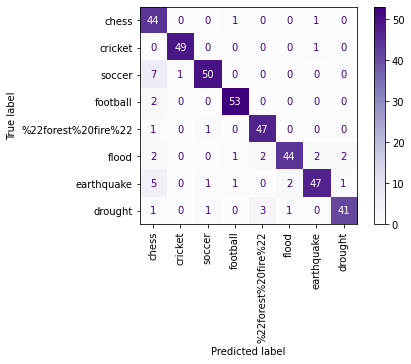

In [ ]:
multi_svm(multi_svm_OvO, lsi_train, lsi_test, train_leaf_labels, test_leaf_labels)

Accuracy: 0.8843373493975903
Precision: 0.8933136992757703
Recall: 0.886259732555764
F-1 Score: 0.8846540101551355


<Figure size 432x288 with 0 Axes>

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


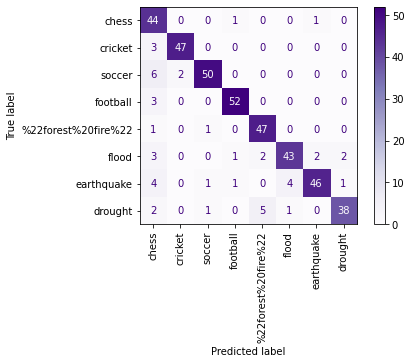

In [ ]:
multi_svm(multi_svm_OvO, nmf_train, nmf_test, train_leaf_labels, test_leaf_labels)

SVM One vs Rest

Accuracy: 0.927710843373494
Precision: 0.9276239259443942
Recall: 0.9278253585849161
F-1 Score: 0.92704207346392


<Figure size 432x288 with 0 Axes>

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


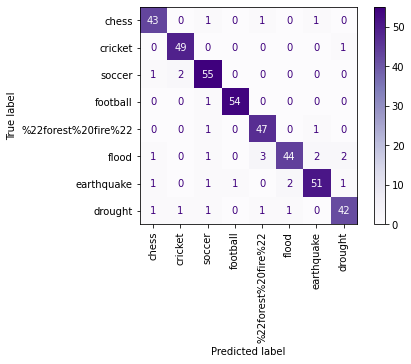

In [ ]:
multi_svm(multi_svm_OvR, lsi_train, lsi_test, train_leaf_labels, test_leaf_labels)

Accuracy: 0.9132530120481928
Precision: 0.912963374515545
Recall: 0.914914330896073
F-1 Score: 0.9126186843320991


<Figure size 432x288 with 0 Axes>

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


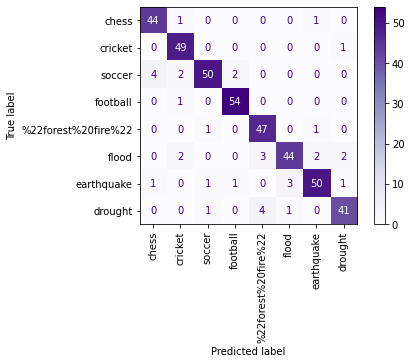

In [ ]:
multi_svm(multi_svm_OvR, nmf_train, nmf_test, train_leaf_labels, test_leaf_labels)

MERGED CASE

Accuracy: 0.9132530120481928
Precision: 0.9162387685106126
Recall: 0.9157027306536097
F-1 Score: 0.9142609486048848


<Figure size 432x288 with 0 Axes>

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


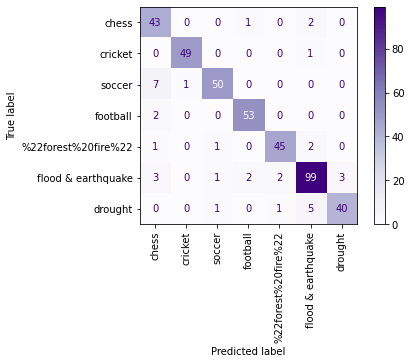

In [ ]:
multi_svm_imbalance(multi_svm_OvO, lsi_train, lsi_test, train_merged_labels, test_merged_labels)

Accuracy: 0.9012048192771084
Precision: 0.9015714989417305
Recall: 0.9012540295878305
F-1 Score: 0.8975781943562301


<Figure size 432x288 with 0 Axes>

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


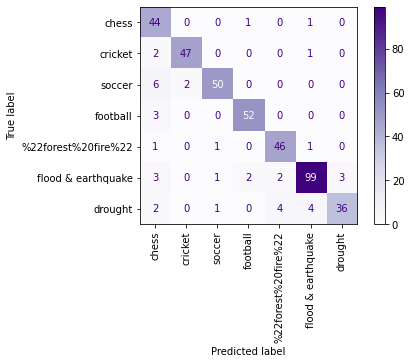

In [ ]:
multi_svm_imbalance(multi_svm_OvO, nmf_train, nmf_test, train_merged_labels, test_merged_labels)

Accuracy: 0.9421686746987952
Precision: 0.9395577379538229
Recall: 0.9451227379300858
F-1 Score: 0.9421092896074313


<Figure size 432x288 with 0 Axes>

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


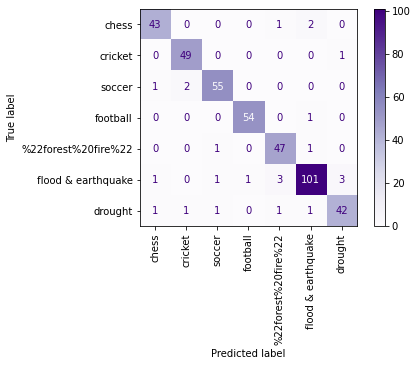

In [ ]:
multi_svm_imbalance(multi_svm_OvR, lsi_train, lsi_test, train_merged_labels, test_merged_labels)

Accuracy: 0.9228915662650602
Precision: 0.9182056229849229
Recall: 0.9272366271032115
F-1 Score: 0.9215369842036151


<Figure size 432x288 with 0 Axes>

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


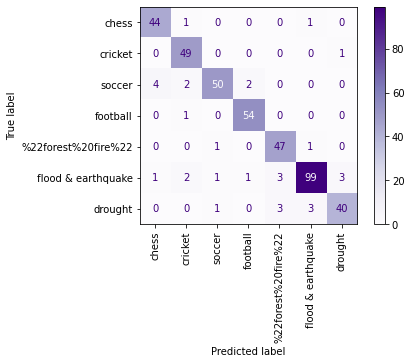

In [ ]:
multi_svm_imbalance(multi_svm_OvR, nmf_train, nmf_test, train_merged_labels, test_merged_labels)

# GLOBAL VECTORS FOR WORD REPRESENTATION (GloVe)

LOADING THE EMBEDDINGS

In [ ]:
embeddings_dict = {}
dimension_of_glove = 300
with open("glove/glove.6B.300d.txt", 'r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], "float32")
    embeddings_dict[word] = vector

UNDERSTANDING THE EMBEDDINGS

In [ ]:
print(np.linalg.norm(embeddings_dict["queen"] - embeddings_dict["king"] - embeddings_dict["wife"] + embeddings_dict["husband"], ord = 2))
print(np.linalg.norm(embeddings_dict["queen"] - embeddings_dict["king"], ord = 2))
print(np.linalg.norm(embeddings_dict["wife"] - embeddings_dict["husband"], ord = 2))

6.1650367
5.966258
3.1520464


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


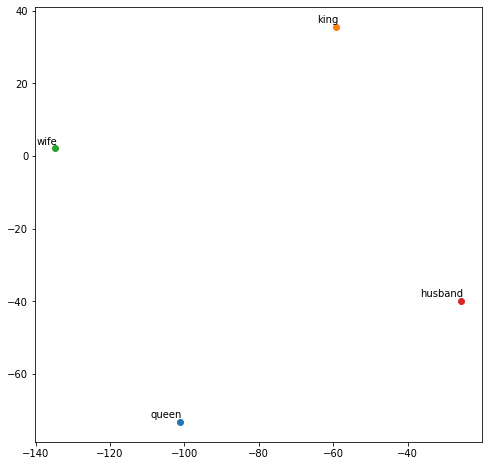

In [ ]:
# Taken as it is from: https://github.com/Suji04/NormalizedNerd/blob/master/Introduction%20to%20NLP/GloVe.ipynb

vocab = ["queen", "king", "wife", "husband"]

def tsne_plot(model):
    labels = []
    wordvecs = []

    for word in vocab:
        wordvecs.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=3, n_components=2, init='pca', random_state=42)
    coordinates = tsne_model.fit_transform(wordvecs)

    x = []
    y = []
    for value in coordinates:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(8,8)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(2, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

tsne_plot(embeddings_dict)

CREATING GLOVE FEATURES

In [ ]:
def create_glove_features(dataset):
    glove_features = []
    for i, sent in enumerate(dataset.full_text):
        sentence_vecs = []
        for word in word_tokenize(sent):
            if word not in embeddings_dict:
                continue
            vec = embeddings_dict[word]
            sentence_vecs.append(vec)
        sentence_vecs = np.mean(np.array(sentence_vecs), axis=0)
        glove_features.append(sentence_vecs)

    glove_features = np.array(glove_features)
    return glove_features

In [ ]:
glove_train_features = create_glove_features(train)
glove_train_labels = train_labels
glove_test_features = create_glove_features(test)
glove_test_labels = test_labels

In [ ]:
print(glove_train_features.shape)
print(glove_train_labels.shape)
print(glove_test_features.shape)
print(glove_test_labels.shape)

(1657, 300)
(1657,)
(415, 300)
(415,)


USING SVM FOR CLASSIFICATION

Average validation accuracy is  0.4843373493975903  when C =  0.001
Average validation accuracy is  0.8923694779116464  when C =  0.01
Average validation accuracy is  0.9208835341365461  when C =  0.1
Average validation accuracy is  0.9465863453815262  when C =  1
Average validation accuracy is  0.9578313253012049  when C =  10
Average validation accuracy is  0.9485943775100403  when C =  100
Average validation accuracy is  0.9429718875502008  when C =  1000
Average validation accuracy is  0.9429718875502008  when C =  10000
Average validation accuracy is  0.9429718875502008  when C =  100000
Average validation accuracy is  0.9429718875502008  when C =  1000000
The model performed best when C =  10
gamma: 10
Accuracy: 0.9686746987951808
Precision: 0.9707207207207207
Recall: 0.9684466019417476
F-1 Score: 0.9686280666864377
--------------------------------------------------
ROC Curve


<Figure size 432x288 with 0 Axes>

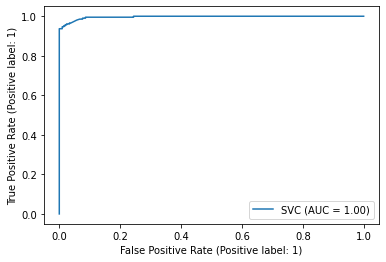

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


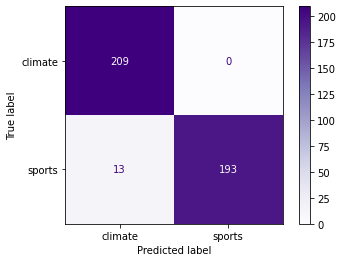

In [ ]:
best_gamma_for_svm_glove = find_optimal_gamma(glove_train_features, glove_train_labels)
fpr,tpr = linear_svm(glove_train_features, glove_test_features, glove_train_labels, glove_test_labels, C=best_gamma_for_svm_glove)

USING LOGISTIC REGRESSION FOR CLASSIFICATION

LOGISTIC REGRESSION WITHOUT REGULARIZATION

lambda: 10000000000000000000000000000000000000000000000000000000000000000
Accuracy: 0.9542168674698795
Precision: 0.9561919432385753
Recall: 0.9539880150508664
F-1 Score: 0.9541487128494089
--------------------------------------------------
ROC Curve


<Figure size 432x288 with 0 Axes>

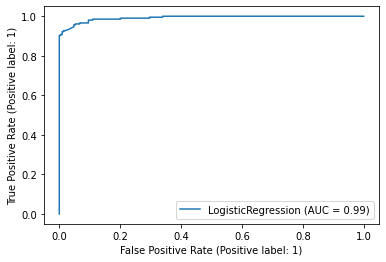

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


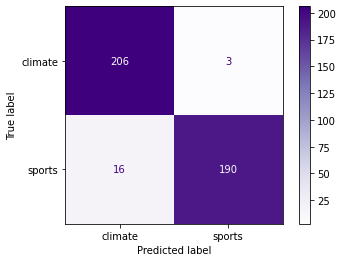

In [ ]:
logistic_regression_without_reg_for_glove = LogisticRegression(penalty='l1', C = 10**64, solver = 'liblinear')
_, _ = logistic_regression_model(logistic_regression_without_reg_for_glove, glove_train_features, glove_test_features, glove_train_labels, glove_test_labels, C=10**64)

LOGISTIC REGRESSION WITH L1 REGULARIZATION

Average validation accuracy is  0.485140562248996  when C =  0.0001
Average validation accuracy is  0.485140562248996  when C =  0.001
Average validation accuracy is  0.485140562248996  when C =  0.01
Average validation accuracy is  0.8642570281124499  when C =  0.1
Average validation accuracy is  0.9373493975903614  when C =  1
Average validation accuracy is  0.9506024096385544  when C =  10
Average validation accuracy is  0.9497991967871485  when C =  100
Average validation accuracy is  0.9518072289156627  when C =  1000
The model performed best when C =  1000
lambda: 1000
Accuracy: 0.963855421686747
Precision: 0.9665178571428572
Recall: 0.9635922330097088
F-1 Score: 0.9637872961762874
--------------------------------------------------
ROC Curve


<Figure size 432x288 with 0 Axes>

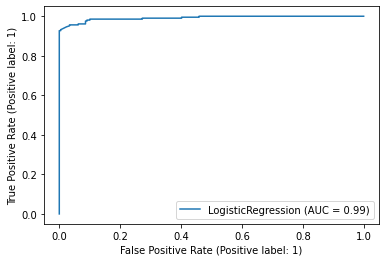

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


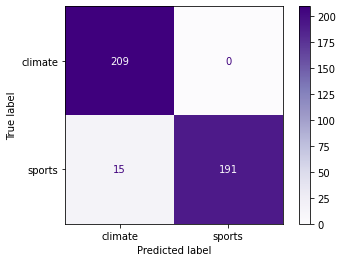

In [ ]:
logistic_regression_l1_for_glove =  LogisticRegression(penalty='l1', solver = 'liblinear')
best_lambda_l1_for_glove = find_optimal_lambda(logistic_regression_l1_for_glove, glove_train_features, glove_train_labels, penalty='l1')
_, _ = logistic_regression_model(logistic_regression_l1_for_glove, glove_train_features, glove_test_features, glove_train_labels, glove_test_labels, C=best_lambda_l1_for_glove)

LOGISTIC REGRESSION WITH L2 REGULARIZATION

Average validation accuracy is  0.7931726907630523  when C =  0.0001
Average validation accuracy is  0.8859437751004016  when C =  0.001
Average validation accuracy is  0.8951807228915662  when C =  0.01
Average validation accuracy is  0.906024096385542  when C =  0.1
Average validation accuracy is  0.9349397590361445  when C =  1
Average validation accuracy is  0.9594377510040161  when C =  10
Average validation accuracy is  0.9590361445783131  when C =  100
Average validation accuracy is  0.9506024096385541  when C =  1000
The model performed best when C =  10
lambda: 10
Accuracy: 0.9662650602409638
Precision: 0.9680109157064888
Recall: 0.96605425744414
F-1 Score: 0.9662209302325582
--------------------------------------------------
ROC Curve


<Figure size 432x288 with 0 Axes>

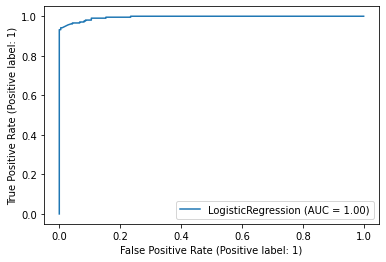

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


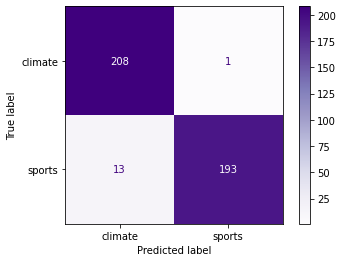

In [ ]:
logistic_regression_l2_for_glove =  LogisticRegression(penalty='l2', solver = 'liblinear')
best_lambda_l2_for_glove = find_optimal_lambda(logistic_regression_l2_for_glove, glove_train_features, glove_train_labels, penalty='l2')
_, _ = logistic_regression_model(logistic_regression_l2_for_glove, glove_train_features, glove_test_features, glove_train_labels, glove_test_labels, C=best_lambda_l2_for_glove)

Accuracy: 0.9325301204819277
Precision: 0.9341325745206885
Recall: 0.9323175546987504
F-1 Score: 0.9324418604651162
--------------------------------------------------
ROC Curve


<Figure size 432x288 with 0 Axes>

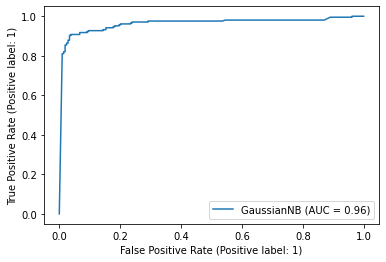

--------------------------------------------------
Confusion Matrix
--------------------------------------------------


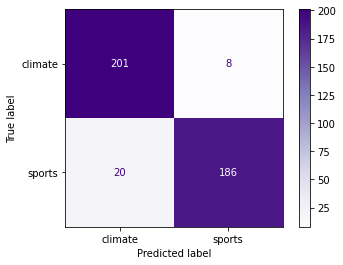

In [ ]:
gnb_for_glove = GaussianNB()
naive_bayes_model(gnb_for_glove, glove_train_features, glove_test_features, glove_train_labels, glove_test_labels, root_label_names, "binary")

GLOVE VISUALIZATIONS

In [ ]:
glove_files = ['glove.6B.50d.txt','glove.6B.100d.txt','glove.6B.200d.txt','glove.6B.300d.txt']
accuracies = list()

for file in glove_files:
    embeddings_dict = {}
    with open("glove/" + file, 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector
    glove_train_features = create_glove_features(train)
    glove_train_labels = train_labels
    glove_test_features = create_glove_features(test)
    glove_test_labels = test_labels
    classifier = svm.SVC(kernel='linear',C=10,random_state=42)
    predictions = classifier.fit(glove_train_features, glove_train_labels).predict(glove_test_features)
    accuracies.append(accuracy_score(glove_test_labels, predictions))  

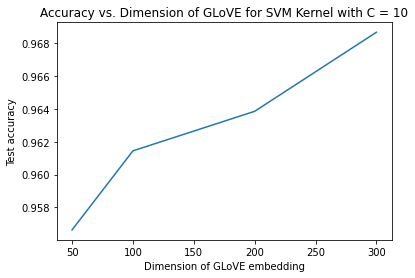

In [ ]:
glove_dimensions = [50,100,200,300]
plt.plot(glove_dimensions, accuracies)
plt.title('Accuracy vs. Dimension of GLoVE for SVM Kernel with C = 10')
plt.xlabel('Dimension of GLoVE embedding')
plt.ylabel('Test accuracy')
plt.show()

VISUALIZATION USING UMAP

In [ ]:
glove_features = np.concatenate((glove_train_features, glove_test_features), axis = 0)
glove_numeric_labels = np.concatenate((glove_train_labels, glove_test_labels), axis = 0)
glove_labels = list()
for i in glove_numeric_labels:
    if i == 0:
        glove_labels.append("sports")
    else:
        glove_labels.append("climate")

glove_labels = np.array(glove_labels)

In [ ]:
print(glove_features.shape)
print(glove_labels.shape)

(2072, 300)
(2072,)


In [ ]:
reducer = umap.UMAP(n_components=2, metric='euclidean')
embedding = umap.UMAP().fit(glove_features)
hover_data = pd.DataFrame({'index':np.arange(glove_features.shape[0]),
                           'label':glove_labels})
hover_data['item'] = hover_data.label.map(
    {
        '0':'Sports',
        '1':'Climate'
    }
)
f = umap.plot.interactive(embedding, labels=glove_labels, hover_data=hover_data, theme='fire')
show(f)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
normalized_random_points = np.random.normal(0, 1, glove_features.shape)
normalized_random_points = normalized_random_points / np.linalg.norm(normalized_random_points)
print(normalized_random_points.shape)
reduced_normal_plot = umap.UMAP(n_components=2, metric='euclidean').fit(normalized_random_points)
embedding_for_normal_plot = reduced_normal_plot.fit(normalized_random_points)
x = umap.plot.interactive(embedding_for_normal_plot, theme='fire')
show(x)